# Importing Library

In [2]:
from jbfg.pandas_utils import *
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score
import joblib
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image


#### 스키마할당

In [2]:
schema = 'l2_jbwc_extnl' 

In [3]:
#(1) Data loading 
sql = 'SELECT * FROM products_info' 
df_products_info = get_df(sql, schema) 
sql = 'SELECT * FROM train_x_past' 
train_x_past = get_df(sql, schema) 
sql = 'SELECT * FROM train_x_current' 
train_x_current = get_df(sql, schema) 
sql = 'SELECT * FROM train_y' 
train_y = get_df(sql, schema) 
sql = 'SELECT * FROM test_x_past' 
test_x_past = get_df(sql, schema) 
sql = 'SELECT * FROM test_x_current' 
test_x_current = get_df(sql, schema)

#(2) pickle 저장 
df_products_info.to_pickle('data/df_products_info.pkl')
train_x_past.to_pickle('data/train_x_past.pkl')
train_x_current.to_pickle('data/train_x_current.pkl')
train_y.to_pickle('data/train_y.pkl')
test_x_past.to_pickle('data/test_x_past.pkl')
test_x_current.to_pickle('data/test_x_current.pkl') 

In [4]:
### pickle 데이터 로딩 
root = 'data/'  
with open(root + 'df_products_info.pkl', 'rb') as f : 
    df_products_info = pickle.load(f)
with open(root + 'train_x_past.pkl', 'rb') as f : 
    train_x_past = pickle.load(f)
with open(root + 'train_x_current.pkl', 'rb') as f : 
    train_x_current = pickle.load(f)
with open(root + 'train_y.pkl', 'rb') as f : 
    train_y = pickle.load(f)
with open(root + 'test_x_past.pkl', 'rb') as f : 
    test_x_past = pickle.load(f)
with open(root + 'test_x_current.pkl', 'rb') as f : 
    test_x_current = pickle.load(f)    

In [5]:
df_dict = {'df_products_info' : df_products_info 
         , 'train_x_past' : train_x_past
         , 'train_x_current': train_x_current
         , 'train_y' : train_y 
         , 'test_x_past' : test_x_past
         , 'test_x_current' : test_x_current}

#### 데이터 구조 확인

In [6]:
for key, val in df_dict.items() : 
    print(key, ' : ', val.shape)

df_products_info  :  (100, 6)
train_x_past  :  (1253972, 9)
train_x_current  :  (24424, 8)
train_y  :  (24424, 1)
test_x_past  :  (541922, 9)
test_x_current  :  (16126, 8)


In [7]:
for key, val in df_dict.items() : 
    print(key, ' \n ', val.head(1), '\n\n')

df_products_info  
    product_id                   name category_id division_id  \
0      21709  Sparkling Lemon Water         115           7   

                   category_name division_name  
0  water seltzer sparkling water     beverages   


train_x_past  
    order_id   cstno order_number week_day order_hour order_interval add_order  \
0   717029  196613           15        1          9            3.0         5   

  is_reordered product_id  
0            0      41220   


train_x_current  
    order_id  cstno order_number week_day order_hour order_interval add_order  \
0   806422  41116           47        5         18            3.0         4   

  is_reordered  
0            1   


train_y  
    product_id
0      21709 


test_x_past  
    order_id   cstno order_number week_day order_hour order_interval add_order  \
0   117004  186630           37        4         11            3.0        12   

  is_reordered product_id  
0            1      21709   


test_x_current  
    

In [8]:
for key, val in df_dict.items() : 
    print(key)
    print(val.isnull().sum(), '\n\n')

df_products_info
product_id       0
name             0
category_id      0
division_id      0
category_name    0
division_name    0
dtype: int64 


train_x_past
order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
dtype: int64 


train_x_current
order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
dtype: int64 


train_y
product_id    0
dtype: int64 


test_x_past
order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
dtype: int64 


test_x_current
order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
dtype: int64 




# Ch2. 데이터 전처리

## 데이터 정합성 check

### (1) product info 데이터 오입력 확인

### (2) order interval 결측 (' ') 확인

In [9]:
# for col in df_products_info.columns : 
#     print(col + ':') 
#     print(df_products_info[col].unique())
    
for key, val in df_dict.items() : 
    print(key)
    print('----------------------')
    for col in val.columns : 
        print(col + ':') 
        print(val[col].unique())
    print('\n')

df_products_info
----------------------
product_id:
['21709' '20995' '33000' '7781' '47144' '41220' '41787' '4210' '38689'
 '42736' '196' '16759' '9387' '4799' '34358' '23909' '43122' '3957'
 '27156' '9839' '46906' '15290' '28199' '18465' '29487' '11520' '27344'
 '8424' '20114' '8174' '33198' '44142' '27521' '33731' '28842' '35221'
 '5785' '22825' '5450' '24838' '39928' '12341' '31506' '25890' '48679'
 '46667' '34969' '24184' '43961' '21938' '9076' '19660' '10749' '43352'
 '35951' '39877' '22035' '34126' '5077' '26604' '41950' '8518' '46979'
 '28985' '44359' '27086' '31717' '30489' '27104' '17794' '21616' '37646'
 '4605' '19057' '44632' '49235' '42265' '45066' '30391' '4920' '40706'
 '8277' '5876' '28204' '49683' '39275' '45007' '24964' '22935' '27966'
 '27845' '26209' '16797' '47626' '47766' '47209' '21903' '21137' '13176'
 '24852']
name:
['Sparkling Lemon Water' 'Organic Broccoli Florets' 'Pure Irish Butter'
 'Organic Sticks Low Moisture Part Skim Mozzarella String Cheese'
 'Unsweete

In [10]:
df_products_info[df_products_info['category_name'] == '4']

Empty DataFrame
Columns: [product_id, name, category_id, division_id, category_name, division_name]
Index: []

In [11]:
df_products_info[df_products_info['division_id'] == '4']['division_name'].unique()

array(['produce'], dtype=object)

In [12]:
df_products_info['category_name'].value_counts()


fresh vegetables                 29
fresh fruits                     24
packaged vegetables fruits        9
milk                              5
water seltzer sparkling water     5
packaged cheese                   4
fresh herbs                       3
soy lactosefree                   3
eggs                              2
butter                            2
frozen produce                    2
packaged produce                  2
cream                             2
canned meals beans                1
bread                             1
soft drinks                       1
lunch meat                        1
fresh dips tapenades              1
refrigerated                      1
oils vinegars                     1
packaged poultry                  1
Name: category_name, dtype: int64

# (1) product info 데이터 오입력 수정


## 데이터 변경

In [13]:
df_products_info.iloc[22] = {'product_id':'28199', 'name':'Clementines Bag', 'category_id':'123', 'division_id':'4'
                            , 'category_name':'packaged vegetables fruits', 'division_name':'produce'}

## 변경내용 확인


In [14]:
df_products_info['category_name'].value_counts()


fresh vegetables                 29
fresh fruits                     24
packaged vegetables fruits        9
milk                              5
water seltzer sparkling water     5
packaged cheese                   4
fresh herbs                       3
soy lactosefree                   3
eggs                              2
butter                            2
frozen produce                    2
packaged produce                  2
cream                             2
canned meals beans                1
bread                             1
soft drinks                       1
lunch meat                        1
fresh dips tapenades              1
refrigerated                      1
oils vinegars                     1
packaged poultry                  1
Name: category_name, dtype: int64

In [15]:
df_products_info['division_name'].value_counts()


produce         67
dairy eggs      18
beverages        7
frozen           2
deli             2
pantry           1
bakery           1
canned goods     1
meat seafood     1
Name: division_name, dtype: int64

# (2) order interval 수정


In [16]:
train_x_past[train_x_past['order_interval'] == ''] # 21686 개indicator


order_id   cstno order_number week_day order_hour order_interval  \
57       1175721  196613            1        6         13                  
112      1175721  196613            1        6         13                  
185      1175721  196613            1        6         13                  
223      2057033   32775            1        0         16                  
258      2057033   32775            1        0         16                  
...          ...     ...          ...      ...        ...            ...   
1253740  1362627  131050            1        0         16                  
1253837  1386303  163819            1        2         11                  
1253861  1386303  163819            1        2         11                  
1253910  1386303  163819            1        2         11                  
1253960  1386303  163819            1        2         11                  

        add_order is_reordered product_id  
57             10            0      24184  
112             5            0      17794  
185             8            0      24852  
223             2            0      38689  
258             4            0      34358  
...           ...          ...        ...  
1253740         4            0      45066  
1253837         7            0      27086  
1253861         1            0      30489  
1253910         8            0       8277  
1253960         4            0      24852  

[21686 rows x 9 columns]

In [17]:
train_x_past[train_x_past['order_interval'] == '']['order_number'].value_counts()


1    21686
Name: order_number, dtype: int64

In [18]:
train_x_past[train_x_past['order_number'] == '1']['order_interval'].value_counts()


    21686
Name: order_interval, dtype: int64

### na 값은 0으로 조정


In [19]:
train_x_past.loc[train_x_past['order_interval'] == '', 'order_interval'] = 0


In [20]:
train_x_past.loc[train_x_past['order_number'] == '1', 'is_first_order'] = 1 
train_x_past.loc[train_x_past['is_first_order'].isnull(), 'is_first_order'] = 0

In [21]:
round(train_x_past['is_first_order'].mean()*100,2)


1.73

# Ch3. concating, merging

In [22]:
train_x_current.loc[train_x_current['order_number'] == '1', 'is_first_order'] = 1 
train_x_current.loc[train_x_current['is_first_order'].isnull(), 'is_first_order'] = 0

In [23]:
# train_y + train_x_current = train_current 
# 경진대회 데이터 세트 설명 內 train x current data와 row별로 매핑된다는 정보로 단순 merge실시 
train_current = pd.concat([train_x_current, train_y], axis=1).sort_values(by=['order_id'], ascending=False).reset_index(drop=True) 
train_current

order_id   cstno order_number week_day order_hour order_interval  \
0       999756  121572           52        6         15            7.0   
1       998879  112292           64        6         19            4.0   
2       998879  112292           64        6         19            4.0   
3       998879  112292           64        6         19            4.0   
4       998879  112292           64        6         19            4.0   
...        ...     ...          ...      ...        ...            ...   
24419  1002074  124234           52        6         15            6.0   
24420  1001312   59365          100        5         16            2.0   
24421  1001139  113656           58        0         18           13.0   
24422  1001080  175275           47        1         12            2.0   
24423  1001080  175275           47        1         12            2.0   

      add_order is_reordered  is_first_order product_id  
0             2            1             0.0       5785  
1             8            1             0.0      16797  
2            11            1             0.0      24852  
3             9            1             0.0      22035  
4             7            1             0.0      27845  
...         ...          ...             ...        ...  
24419         5            1             0.0      41220  
24420         3            1             0.0       9076  
24421         2            1             0.0      24852  
24422         2            1             0.0      47209  
24423         5            1             0.0      22935  

[24424 rows x 10 columns]

In [24]:
train_current['is_past_current'] = 'current' 
train_current

order_id   cstno order_number week_day order_hour order_interval  \
0       999756  121572           52        6         15            7.0   
1       998879  112292           64        6         19            4.0   
2       998879  112292           64        6         19            4.0   
3       998879  112292           64        6         19            4.0   
4       998879  112292           64        6         19            4.0   
...        ...     ...          ...      ...        ...            ...   
24419  1002074  124234           52        6         15            6.0   
24420  1001312   59365          100        5         16            2.0   
24421  1001139  113656           58        0         18           13.0   
24422  1001080  175275           47        1         12            2.0   
24423  1001080  175275           47        1         12            2.0   

      add_order is_reordered  is_first_order product_id is_past_current  
0             2            1             0.0       5785         current  
1             8            1             0.0      16797         current  
2            11            1             0.0      24852         current  
3             9            1             0.0      22035         current  
4             7            1             0.0      27845         current  
...         ...          ...             ...        ...             ...  
24419         5            1             0.0      41220         current  
24420         3            1             0.0       9076         current  
24421         2            1             0.0      24852         current  
24422         2            1             0.0      47209         current  
24423         5            1             0.0      22935         current  

[24424 rows x 11 columns]

In [25]:
train_x_past['is_past_current'] = 'past'
train_x_past

order_id   cstno order_number week_day order_hour order_interval  \
0         717029  196613           15        1          9            3.0   
1        2325772  196613           35        6         11            2.0   
2         642668  196613           69        2         16            2.0   
3        1326515  196613           61        3         19            3.0   
4        1437845  196613           36        3         15            4.0   
...          ...     ...          ...      ...        ...            ...   
1253967  1902783  163819           47        0         19           13.0   
1253968  1969590  163819           42        1         15            6.0   
1253969  2549215  163819            9        1         11            7.0   
1253970  3103211  163819           39        1         14            7.0   
1253971  3207262  163819            8        1         12            7.0   

        add_order is_reordered product_id  is_first_order is_past_current  
0               5            0      41220             0.0            past  
1               7            1      41220             0.0            past  
2              11            1       4210             0.0            past  
3               3            1       4210             0.0            past  
4              16            0       4210             0.0            past  
...           ...          ...        ...             ...             ...  
1253967         2            1      24852             0.0            past  
1253968         3            1      24852             0.0            past  
1253969         1            1      24852             0.0            past  
1253970         3            1      24852             0.0            past  
1253971         1            1      24852             0.0            past  

[1253972 rows x 11 columns]

In [26]:
# train_x_past + train_current = train_current_past 
train_current_past = pd.concat([train_x_past, train_current]).sort_values(by=['order_id'], ascending=False).reset_index(drop=True) 
train_current_past

order_id  cstno order_number week_day order_hour order_interval  \
0         999996  34552           14        5         17            5.0   
1         999996  34552           14        5         17            5.0   
2         999996  34552           14        5         17            5.0   
3         999974  94872           40        6          9            3.0   
4         999974  94872           40        6          9            3.0   
...          ...    ...          ...      ...        ...            ...   
1278391  1000003    444           32        5         19            7.0   
1278392  1000003    444           32        5         19            7.0   
1278393  1000003    444           32        5         19            7.0   
1278394  1000003    444           32        5         19            7.0   
1278395  1000003    444           32        5         19            7.0   

        add_order is_reordered product_id  is_first_order is_past_current  
0               1            1      49683             0.0            past  
1               8            1      24852             0.0            past  
2               3            1      18465             0.0            past  
3               9            1      26209             0.0            past  
4               1            1      21616             0.0            past  
...           ...          ...        ...             ...             ...  
1278391         4            1      24184             0.0            past  
1278392        16            1      16797             0.0            past  
1278393        28            1      27966             0.0            past  
1278394         7            1      45007             0.0            past  
1278395         6            1      47626             0.0            past  

[1278396 rows x 11 columns]

In [27]:
# df_products_info + train_current_past = base_df 
base_df = pd.merge(left = train_current_past, right = df_products_info, left_on = 'product_id', right_on = 'product_id').sort_values(by=['order_id'], ascending=False).reset_index(drop=True) 
base_df

order_id  cstno order_number week_day order_hour order_interval  \
0         999996  34552           14        5         17            5.0   
1         999996  34552           14        5         17            5.0   
2         999996  34552           14        5         17            5.0   
3         999974  94872           40        6          9            3.0   
4         999974  94872           40        6          9            3.0   
...          ...    ...          ...      ...        ...            ...   
1278391  1000003    444           32        5         19            7.0   
1278392  1000003    444           32        5         19            7.0   
1278393  1000003    444           32        5         19            7.0   
1278394  1000003    444           32        5         19            7.0   
1278395  1000003    444           32        5         19            7.0   

        add_order is_reordered product_id  is_first_order is_past_current  \
0               1            1      49683             0.0            past   
1               3            1      18465             0.0            past   
2               8            1      24852             0.0            past   
3               9            1      26209             0.0            past   
4               1            1      21616             0.0            past   
...           ...          ...        ...             ...             ...   
1278391        28            1      27966             0.0            past   
1278392         4            1      24184             0.0            past   
1278393         8            1      21938             0.0            past   
1278394         7            1      45007             0.0            past   
1278395        16            1      16797             0.0            past   

                                                name category_id division_id  \
0                                     Cucumber Kirby          83           4   
1        Organic Grade A Free Range Large Brown Eggs          86          16   
2                                             Banana          24           4   
3                                              Limes          24           4   
4                               Organic Baby Arugula         123           4   
...                                              ...         ...         ...   
1278391                          Organic Raspberries         123           4   
1278392                                  Red Peppers          83           4   
1278393                            Green Bell Pepper          83           4   
1278394                             Organic Zucchini          83           4   
1278395                                 Strawberries          24           4   

                      category_name division_name  
0                  fresh vegetables       produce  
1                              eggs    dairy eggs  
2                      fresh fruits       produce  
3                      fresh fruits       produce  
4        packaged vegetables fruits       produce  
...                             ...           ...  
1278391  packaged vegetables fruits       produce  
1278392            fresh vegetables       produce  
1278393            fresh vegetables       produce  
1278394            fresh vegetables       produce  
1278395                fresh fruits       produce  

[1278396 rows x 16 columns]

In [28]:
# 불필요한 데이터 drop 
del df_products_info, train_x_past, train_x_current, train_y, test_x_past, test_x_current

In [29]:
# 수정된 df의 데이터형식 파악
base_df.dtypes

order_id            object
cstno               object
order_number        object
week_day            object
order_hour          object
order_interval      object
add_order           object
is_reordered        object
product_id          object
is_first_order     float64
is_past_current     object
name                object
category_id         object
division_id         object
category_name       object
division_name       object
dtype: object

In [30]:
# base_df 전 type 변경 

In [31]:
base_df = base_df.astype({
        'order_id' : 'object',  
        'cstno' : 'object',  
        'order_number' : 'int',  
        'week_day' : 'object',  
        'order_hour' : 'float64',  
        'order_interval' : 'float64',   
        'add_order' : 'int',  
        'is_reordered' : 'int',  
        'product_id' : 'object', 
        'is_past_current' : 'object',  
        'is_first_order' : 'int', 
        'name' : 'object',   
        'category_id' : 'object',  
        'division_id' : 'object',
        'category_name' : 'object', 
        'division_name' : 'object'
})

In [32]:
base_df.dtypes

order_id            object
cstno               object
order_number         int64
week_day            object
order_hour         float64
order_interval     float64
add_order            int64
is_reordered         int64
product_id          object
is_first_order       int64
is_past_current     object
name                object
category_id         object
division_id         object
category_name       object
division_name       object
dtype: object

# Ch4. eda

### [1] train data 내 past Data, current Data 비중 비교

### EDA 분석 데이터로 past & current 결합한 데이터를 사용하였기에, 사전에 past & current data 비중을 확인하고자 함. 비중확인 결과 Past 데이터의 비중이 약 98%를 차지함.

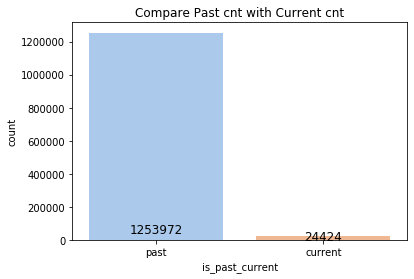

In [33]:
ax = sns.countplot(x='is_past_current', data=base_df, palette = sns.color_palette("pastel"))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height/30, height, ha='center', size=12)
plt.title('Compare Past cnt with Current cnt') 
plt.show()
plt.close()

### [2] 재구매여부 비중 확인 재구매 (is_reordered = 1) 및 첫구매 비중(is_reordered = 0) 확인

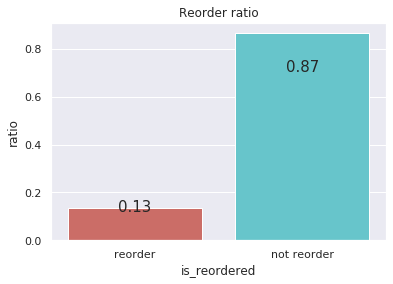

In [34]:
sns.set_theme()
reorder_prop = base_df['is_reordered'].value_counts(normalize = True) # 재구매 비중
ax = sns.barplot(x=reorder_prop.index, y=reorder_prop.values, palette='hls') 
ax.set_ylabel('ratio') 
ax.set_xlabel('is_reordered') 
ax.set_xticklabels(['reorder','not reorder']) # 재구매, 첫구매 비중 확인 
ax.set_title('Reorder ratio')

for p in ax.patches: 
    txt = str(p.get_height().round(2)) 
    txt_x = p.get_x() + p.get_width()/2. 
    txt_y = 0.8*p.get_height() 
    ax.text(txt_x, txt_y, txt, fontsize=15,ha='center', va='bottom') 
#전체 구매내역에서 재구매데이터는 87% 비율을 가짐

In [35]:
del reorder_prop

### [3] 과거(past)와 현재(current)의 재구매율 비교

### Past Data와 Current Data의 재구매율 각각 확인

### 두 데이터의 재구매율이 8%p 내외로 차이남

In [36]:
base_df.groupby('is_past_current')['is_reordered'].mean()*100

is_past_current
current    94.116443
past       86.427289
Name: is_reordered, dtype: float64

### 전체건 및 재구매건 대상으로 구매 상품(최소 1건이상)의 상품별 비중을 확인해보고, 비중이 높은 상위 20개 상품을 시각화

> 상품종류 100건 모두 1건 이상 구매 (한번도 구매 하지 않은 상품 無)

> rank = 상품별 주문건수 / order_id 건수, rank top 20개 계산

In [37]:
# 상품 종류는 총 몇건인지
print('총 {}건'.format(base_df['name'].nunique())) 
print('----------------------------------------')
print(base_df['name'].unique())

총 100건
----------------------------------------
['Cucumber Kirby' 'Organic Grade A Free Range Large Brown Eggs' 'Banana'
 'Limes' 'Organic Baby Arugula' 'Organic Unsweetened Almond Milk'
 'Organic Garlic' 'Organic Strawberries' 'Large Lemon'
 'Organic Baby Spinach' 'Organic Blackberries' 'Organic Tomato Cluster'
 'Organic Avocado' 'Spring Water' 'Organic Blueberries'
 'Sparkling Water Grapefruit' 'Organic Yellow Onion'
 'Bag of Organic Bananas' 'Organic Whole String Cheese'
 'Organic Reduced Fat 2% Milk' 'Organic Half & Half' 'Granny Smith Apples'
 '100% Raw Coconut Water' 'Organic Small Bunch Celery'
 'Organic Bartlett Pear' 'Organic Baby Carrots' 'Original Hummus'
 'Organic Granny Smith Apple' 'Organic Lacinato (Dinosaur) Kale'
 'Organic Black Beans' 'Organic Fuji Apple'
 'Organic Peeled Whole Baby Carrots' 'Hass Avocados' 'Organic Broccoli'
 'Michigan Organic Kale' 'Organic Cucumber' 'Organic Grape Tomatoes'
 'Yellow Onions' 'Unsalted Butter' 'Organic Garnet Sweet Potato (Yam)'
 '2%

### [4] 전체건의 비중 현황 및 상위 20개 시각화

In [38]:
def calculate_rank(df) :
    # 상품별 rank 계산 (상품별 주문건수 / 전체 주문건수)
    prdt_df = df.groupby(['name']).size().reset_index(name='order_size').sort_values(by='order_size', ascending=False)
    prdt_df['order_ratio'] = prdt_df['order_size']/df['order_id'].nunique()
    prdt_df.set_index('name', inplace=True) 
    prdt_df['rank'] = prdt_df['order_ratio'].rank(ascending=False) 
    prdt_df = prdt_df.round(3) 
    print(prdt_df)
    return prdt_df

In [39]:
def draw_rank(prdt_df) :
    # 구매이력있는 상품비중 상위 20가지를 택하여 vertical chart로 구성
    prdt_df_20 = prdt_df.head(20)
    y_pos = prdt_df_20.index

    plt.barh(y_pos, prdt_df_20['order_ratio'], align='center', alpha=0.8, color='blue')
    plt.xlabel('order ratio')
    plt.title('Top 20 Importance In Ordered Product')
    plt.gca().invert_yaxis()
    plt.show 

                                                order_size  order_ratio   rank
name                                                                          
Banana                                               76026        0.219    1.0
Bag of Organic Bananas                               68949        0.198    2.0
Organic Strawberries                                 54032        0.155    3.0
Organic Hass Avocado                                 43298        0.125    4.0
Organic Baby Spinach                                 40795        0.117    5.0
...                                                    ...          ...    ...
Garlic                                                4308        0.012   96.0
Unsweetened Original Almond Breeze Almond Milk        4191        0.012   97.0
Roma Tomato                                           3907        0.011   98.0
2% Reduced Fat Milk                                   3598        0.010   99.0
Soda                                                

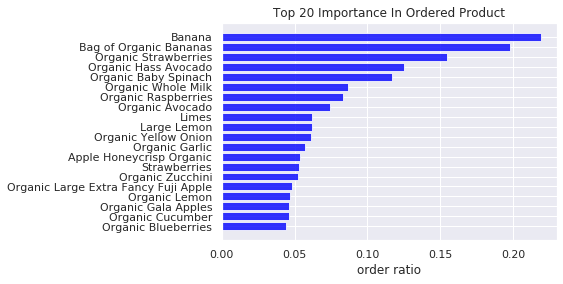

In [40]:
draw_rank(calculate_rank(base_df))

### [5] 재구매건의 비중 현황 및 상위 20개 시각화

                        order_size  order_ratio   rank
name                                                  
Banana                       72421        0.219    1.0
Bag of Organic Bananas       65018        0.197    2.0
Organic Strawberries         49613        0.150    3.0
Organic Hass Avocado         39813        0.121    4.0
Organic Baby Spinach         37108        0.112    5.0
...                            ...          ...    ...
Garlic                        3428        0.010   96.0
2% Reduced Fat Milk           3319        0.010   97.0
Roma Tomato                   3234        0.010   98.0
Red Onion                     3190        0.010   99.0
Soda                          2580        0.008  100.0

[100 rows x 3 columns]


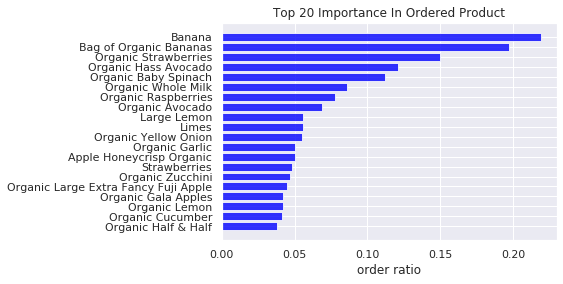

In [41]:
draw_rank(calculate_rank(base_df.loc[base_df['is_reordered']==1]))

### [6] 상품별 재구매율 체크 (고객기준 중복제거)

> 최초 구매 상품 비중이 높으면, 재구매 상품 비중에서도 차지하는 비중이 높게 나타남.

> 실질적으로 '재구매율 자체가 높은 상품을 파악하기 위해선, 각각의 고객이 특정 상품을 구매 했을때 해당 상품이 고객별로 재구매가 이루어지는지 확인 (상품별, 고객별 중복 제거후 재구매율 확인)

> 위에서 본 재구매 비중과 아래의 재구매율 비중을 보았을 때, 상위 20개의 항목은 전반적으로 비슷한 결과를 보였으나, 일부 상품의 우선순위가 바뀌거나 새로운 항목이 등장함 (Large Alfresco Eggs, Sparkling Water Grapefruit 등)

In [65]:
def calcul_reord_rate_dup(df, dup_cols_1, dup_cols_2, by_col) :
    # dup_cols_1 기준 중복제거 후 최초 구매건만 추출
    user_drop_df = df.drop_duplicates(dup_cols_1, keep = 'first') 
    user_drop_df = user_drop_df.loc[user_drop_df['is_reordered']==0]
    x_data = user_drop_df.groupby([by_col])[by_col].count()
    x_data = x_data.reset_index(name='First_prod').sort_values(by=by_col, ascending=False)
    
    # dup_cols_2 기준 중복제거 후 재구매건만 추출
    user_drop_base_df_1 = base_df.drop_duplicates(dup_cols_2, keep = 'first') 
    user_drop_base_df_1 = user_drop_base_df_1.loc[user_drop_base_df_1['is_reordered']==1]  
    x_data1 = user_drop_base_df_1.groupby([by_col])[by_col].count()
    x_data1 = x_data1.reset_index(name='Reord_prod').sort_values(by=by_col, ascending=False)

    final_x=pd.merge(x_data,x_data1, on = by_col)
    final_x['order_ratio'] = final_x['Reord_prod']/final_x['First_prod']
    final_x['rank'] = final_x['order_ratio'].rank(ascending=False)
    final_x = final_x.sort_values(by=['rank'])
    return final_x 

In [43]:
#  상품별, 고객별, 재구매 여부 기준 중복 제거
user_drop_base_df = base_df.drop_duplicates(['product_id','cstno','is_reordered','name'], keep = 'first')

# 상품별 최초구매상품 고객수 카운트
user_drop_base_df = user_drop_base_df.loc[user_drop_base_df['is_reordered']==0]
x_data = user_drop_base_df.groupby(['product_id','name'])['product_id'].count()
x_data = x_data.reset_index(name='First').sort_values(by='product_id', ascending=False)

# 상품별 재구매상품 고객수 카운트
user_drop_base_df_1 = base_df.drop_duplicates(['cstno','product_id','is_reordered'], keep = 'first')
user_drop_base_df_1 = user_drop_base_df_1.loc[user_drop_base_df_1['is_reordered']==1]

x_data1 = user_drop_base_df_1.groupby(['product_id'])['product_id'].count()
x_data1 = x_data1.reset_index(name='Second').sort_values(by='product_id', ascending=False)

# 재구매율 산출

final_x = pd.merge(x_data,x_data1, on='product_id')
final_x['reordered_ratio'] = final_x['Second']/final_x['First']

final_x['rank'] = final_x['reordered_ratio'].rank(ascending=False)

final_x = final_x.sort_values(by=['rank'])
final_x

product_id                    name  First  Second  reordered_ratio   rank
85      21137    Organic Strawberries   4419    3954         0.894773    1.0
96      13176  Bag of Organic Bananas   3931    3480         0.885271    2.0
74      24852                  Banana   3605    3166         0.878225    3.0
82      21903    Organic Baby Spinach   3687    3204         0.868999    4.0
19      47209    Organic Hass Avocado   3485    3022         0.867145    5.0
..        ...                     ...    ...     ...              ...    ...
94      16759    Organic Carrot Bunch   1403     878         0.625802   96.0
60      28842        Bunched Cilantro   1419     887         0.625088   97.0
87      20114        Jalapeno Peppers   1332     806         0.605105   98.0
2        9076             Blueberries   1524     901         0.591207   99.0
95      15290      Orange Bell Pepper   1175     686         0.583830  100.0

[100 rows x 6 columns]

<function matplotlib.pyplot.show(*args, **kw)>

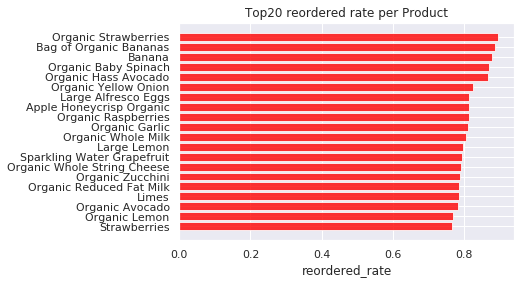

In [44]:
# 재구매비율이 높은 상품 상위 20가지를 택하여 vertical chart로 구성

re_prdt_df_20 = final_x.head(20)
y_pos = re_prdt_df_20['name']

plt.barh(y_pos,re_prdt_df_20['reordered_ratio'], align='center', alpha=0.8, color='red')
plt.xlabel('reordered_rate')
plt.title('Top20 reordered rate per Product')
plt.gca().invert_yaxis()
plt.show

### [7] 재구매율 Top, Low 건 데이터 체크

> 상품별 재구매율이 높은 Banana 데이터를 들여다봤을때, 전체 Banana 구매건 중 95%가 재구매임. Banana구매건은 3605명이 샀고, 재주문은 72,421건 발생했음

> 상품별 재구매율이 낮은 Extra Virgin Olive Oil 데이터를 들여다봤을때, 전체 Extra Virgin Olive Oil 구매건 중 71%가 재구매이며, 이 구매건은 2168고, 재주문은 5,386건 발생했음

In [45]:
base_df.groupby('name')['is_reordered'].mean().sort_values(ascending = False)

name
Banana                      0.952582
Bag of Organic Bananas      0.942987
Organic Reduced Fat Milk    0.942813
Soda                        0.936819
Organic Whole Milk          0.933474
                              ...   
Blueberries                 0.757131
Jalapeno Peppers            0.749341
Bunched Cilantro            0.730382
Red Onion                   0.720416
Extra Virgin Olive Oil      0.713000
Name: is_reordered, Length: 100, dtype: float64

In [46]:
print('가장 재구매 비중 높은 Banana : ' , base_df[base_df['name']=='Banana'].shape)
print('구매 고객 수 : ' , len(base_df[base_df['name']=='Banana']['cstno'].unique())) # 3605명 
print('재주문 건수 : ' , sum(base_df[base_df['name']=='Banana']['is_reordered']))   # 재주문 72,421번

가장 재구매 비중 높은 Banana :  (76026, 16)
구매 고객 수 :  3605
재주문 건수 :  72421


In [47]:
print('가장 재구매 비중 낮은 Extra Virgin Olive Oil : ' , base_df[base_df['name']=='Extra Virgin Olive Oil'].shape)
print('구매 고객 수 : ' , len(base_df[base_df['name']=='Extra Virgin Olive Oil']['cstno'].unique())) # 2168명
print('재주문 건수 : ' , sum(base_df[base_df['name']=='Extra Virgin Olive Oil']['is_reordered'])) # 5386번

가장 재구매 비중 낮은 Extra Virgin Olive Oil :  (7554, 16)
구매 고객 수 :  2168
재주문 건수 :  5386


### [8] 주문건 대상 고객 분포

> 한 고객당 주문한 건수(주문id기준)의 분포를 보자. 최소 43번 주문, 최대 100번 주문함 (다만 하나의 주문건 안에 여러 개의 상품이 포함되어 있을 수 있음)

Min orders per user :  43
Max orders per user :  100


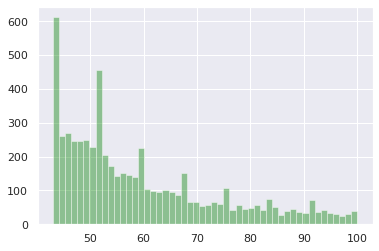

In [48]:
orders_count = base_df.groupby(['cstno'])['order_id'].agg(lambda x : len(x.unique())).reset_index(name='order_count').set_index('cstno')
print("Min orders per user : ", orders_count['order_count'].min()) # 43개
print("Max orders per user : ", orders_count['order_count'].max()) # 100개 
plt.hist(orders_count['order_count'], color = 'green', alpha = 0.4, bins = 50)
plt.show()

In [49]:
del orders_count

### [9] 상품별 재구매율 히스토그램 (확률밀도)

### 재구매율에 대한 상품의 분포를 구성, 0.8~0.85의 재구매율을 보이는 상품들이 가장 많은 포션을 차지함.

### 대체적으로 70%이상의 재구매율을 보이는 것으로 확인

In [50]:
base_df_2 = base_df[['product_id','name','category_id','division_id']].drop_duplicates()


In [51]:
num_of_times_product_ordered = base_df.groupby('product_id')['is_reordered'].count().rename('#times_ordered').reset_index()
num_of_times_product_reordered = base_df.groupby('product_id')['is_reordered'].sum().rename('#times_reordered').reset_index().astype({'#times_reordered':'int64'})
prod_info = num_of_times_product_ordered.merge(base_df_2,on='product_id',how='left')
prod_info = prod_info.merge(num_of_times_product_reordered,on='product_id',how='left')

# 재구매확률 p(reorder|product) = 재구매건수 / 구매건수
prod_info['p(reorder|product)'] = prod_info.apply(lambda row: row['#times_reordered']/row['#times_ordered'] if (row['#times_ordered']!=0) else 0.0,axis='columns')
prod_info['#first_purchase'] = prod_info['#times_ordered'] - prod_info['#times_reordered']
prod_info

product_id  #times_ordered                     name category_id  \
0       10749           11475  Organic Red Bell Pepper          83   
1       11520            7095      Large Alfresco Eggs          86   
2       12341            7389            Hass Avocados          32   
3       13176           68949   Bag of Organic Bananas          24   
4       15290            5230       Orange Bell Pepper          83   
..        ...             ...                      ...         ...   
95       8424            6171           Broccoli Crown          83   
96       8518           11309        Organic Red Onion          83   
97       9076            6275              Blueberries         116   
98       9387            4632      Granny Smith Apples          24   
99       9839            7044         Organic Broccoli          83   

   division_id  #times_reordered  p(reorder|product)  #first_purchase  
0            4              9424            0.821264             2051  
1           16              6382            0.899507              713  
2            4              6574            0.889701              815  
3            4             65018            0.942987             3931  
4            4              4055            0.775335             1175  
..         ...               ...                 ...              ...  
95           4              5130            0.831308             1041  
96           4              8905            0.787426             2404  
97           1              4751            0.757131             1524  
98           4              3848            0.830743              784  
99           4              6072            0.862010              972  

[100 rows x 8 columns]

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


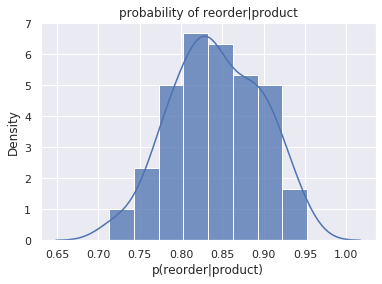

In [52]:
sns.histplot(x=prod_info['p(reorder|product)'],stat='density')
sns.kdeplot(x=prod_info['p(reorder|product)'])
plt.title('probability of reorder|product');

### [10] 주문순번별 재구매율 파악

### 각 주문순번들을 기준으로 합계(재구매건) / 합계(전체구매건)로 재구매율을 산출

### 주문순번 1이후 점차적으로 재구매율이 상승 추세, 이후 특정 순번기점으로 0.8~0.9 횡보하는 듯한 비슷한 재구매율을 보임

### 즉 주문순번이 높을수록 재구매율도 높다는 상식에 부합

In [53]:
reordered_order_num_ds = base_df.groupby(['order_number','is_reordered']).agg({'product_id':len})
reordered_order_num_ds = reordered_order_num_ds.reset_index().pivot(index='order_number', columns='is_reordered', values='product_id')
reordered_order_num_ds['reorder_rate'] = reordered_order_num_ds[1] /reordered_order_num_ds.sum(axis=1)
avg_reordered_rate = round(reordered_order_num_ds[1].sum() / reordered_order_num_ds[[0,1]].sum().sum(),2)
reordered_order_num_ds.fillna(0, inplace=True)
reordered_order_num_ds

is_reordered        0        1  reorder_rate
order_number                                
1             21686.0      0.0      0.000000
2             12082.0   8059.0      0.400129
3              8874.0  11212.0      0.558200
4              7124.0  12774.0      0.641974
5              5907.0  13594.0      0.697092
...               ...      ...           ...
96              118.0   2147.0      0.947903
97              103.0   1960.0      0.950073
98               99.0   1920.0      0.950966
99               97.0   1784.0      0.948432
100             107.0   1953.0      0.948058

[100 rows x 3 columns]

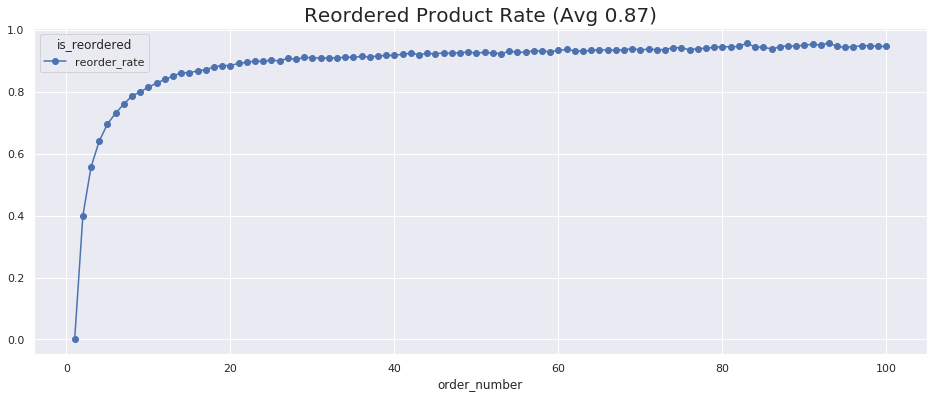

In [54]:
reordered_order_num_ds[['reorder_rate']].plot(kind='line', marker='o',figsize=(16,6))
plt.title("Reordered Product Rate (Avg {})".format(avg_reordered_rate), fontsize=20)
plt.show()

### [11] 카트에 담은 순서(장바구니 순번) 에 따른 재구매율

> 최초 구매시에 상품을 카트에 담는 순번이 빠를수록 재구매율이 높은 추세를 보임.

In [55]:
# 최초 구매리스트 생성_ 최초 고객별, 상품별 구매 리스트 (is_reordered == 0)
First_drop_base_df = base_df.loc[base_df['is_reordered']==0]

# 재구매 리스트 생성_ 상품별, 고객별 중복제거 (is_reordered == 1)
Repurchase_drop_base_df = base_df.loc[base_df['is_reordered']==1]
Repurchase_drop_base_df = Repurchase_drop_base_df.drop_duplicates(['product_id','cstno'], keep = 'first') 

# 재구매를 확인 할 수 있는 플레그 컬럼 생성
Repurchase_drop_base_df = Repurchase_drop_base_df.loc[:,['product_id','cstno']]
Repurchase_drop_base_df['check'] = 1
Repurchase_drop_base_df

# 테이블 병합으로 최초 재구매 했을 경우 check == 1 로 표시
Repurchase_product_check = pd.merge(First_drop_base_df, Repurchase_drop_base_df, on = ['product_id', 'cstno'], how='left')
Repurchase_product_check = Repurchase_product_check.fillna(0)
Repurchase_product_check

order_id   cstno  order_number week_day  order_hour  order_interval  \
0         99997   97689             9        3        12.0            11.0   
1         99995  202946             1        5         7.0             0.0   
2         99995  202946             1        5         7.0             0.0   
3         99995  202946             1        5         7.0             0.0   
4         99995  202946             1        5         7.0             0.0   
...         ...     ...           ...      ...         ...             ...   
171630  1000154   26164            47        0        10.0             7.0   
171631  1000121  108553             2        1         8.0             7.0   
171632  1000121  108553             2        1         8.0             7.0   
171633  1000105  152514            52        3        12.0             0.0   
171634  1000059   57287            29        4        16.0             9.0   

        add_order  is_reordered product_id  is_first_order is_past_current  \
0              15             0      41950               0            past   
1               8             0      44359               1            past   
2               9             0      43122               1            past   
3               3             0      42265               1            past   
4               6             0      30489               1            past   
...           ...           ...        ...             ...             ...   
171630         13             0      21616               0            past   
171631          2             0      47209               0            past   
171632         16             0      40706               0            past   
171633          3             0      21137               0            past   
171634          1             0      21137               0            past   

                              name category_id division_id  \
0           Organic Tomato Cluster          83           4   
1       Organic Small Bunch Celery          83           4   
2            Organic Bartlett Pear          24           4   
3             Organic Baby Carrots         123           4   
4                  Original Hummus          67          20   
...                            ...         ...         ...   
171630        Organic Baby Arugula         123           4   
171631        Organic Hass Avocado          24           4   
171632      Organic Grape Tomatoes         123           4   
171633        Organic Strawberries          24           4   
171634        Organic Strawberries          24           4   

                     category_name division_name  check  
0                 fresh vegetables       produce    1.0  
1                 fresh vegetables       produce    1.0  
2                     fresh fruits       produce    1.0  
3       packaged vegetables fruits       produce    1.0  
4             fresh dips tapenades          deli    1.0  
...                            ...           ...    ...  
171630  packaged vegetables fruits       produce    0.0  
171631                fresh fruits       produce    1.0  
171632  packaged vegetables fruits       produce    1.0  
171633                fresh fruits       produce    1.0  
171634                fresh fruits       produce    1.0  

[171635 rows x 17 columns]

In [56]:
# add_order별 구매 건수 확인 
x_data1 = Repurchase_product_check.groupby(['add_order','check'])['add_order'].count()
x_data1 = x_data1.reset_index(name='count').sort_values(by='count', ascending=False)
x_data1

# add_order별 전체구매 건수 확인
test_sum = x_data1.groupby('add_order').sum().reset_index()
test_sum = test_sum.loc[:,['add_order','count']]
test_sum.rename(columns = {'count':'counts'}, inplace=True)
test_sum

add_order  counts
0           1   14406
1           2   12796
2           3   12362
3           4   12126
4           5   11890
..        ...     ...
70         72       1
71         73       1
72         84       1
73        108       1
74        110       1

[75 rows x 2 columns]

In [57]:
# 장바구니 순번 별 재구매율 확인
final_x=pd.merge(x_data1,test_sum, on='add_order')
final_x['repurchase_ratio'] = final_x['count'] / final_x['counts']
final_x =final_x.loc[(final_x['check']==1) & (final_x['count']>100),].sort_values(by=['repurchase_ratio'],ascending = False)
final_x.head(20)

# 장바구니 순번 별 재구매율 시각화
final_x = final_x.sort_values(by=['add_order'],ascending = True)
color = sns.color_palette()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


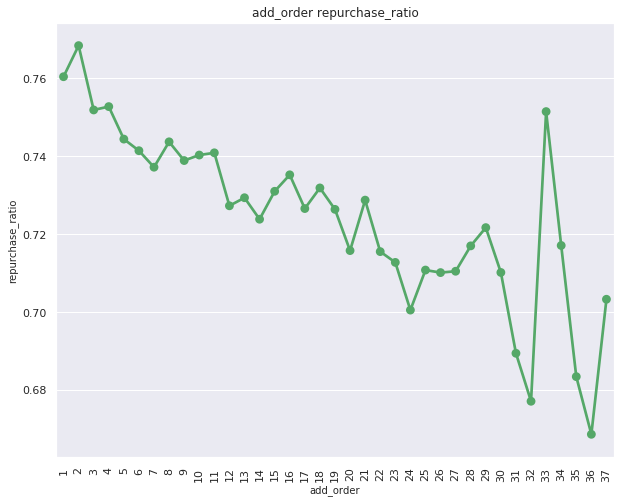

In [58]:
plt.figure(figsize=(10,8))
sns.pointplot(final_x['add_order'].values, final_x['repurchase_ratio'].values, alpha=0.8, color=color[2])
plt.ylabel('repurchase_ratio', fontsize=10)
plt.xlabel('add_order', fontsize=10)
plt.title("add_order repurchase_ratio", fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### [12] 부서별 구매건, 재구매건 차지 비중

> produce 부서의 상품 구매건수가 78%로 압도적인 비중을 차지함

> 전체 구매건 비중과 유사하게 produce 부서의 상품 재구매건수가 77%로 압도적인 비중을 차지함.

In [59]:
def draw_pie_chart(df, col) : 
    x_data = df.groupby([col])[col].count()
    total = x_data.sum()
    x_data = x_data.reset_index(name='count').sort_values(by='count', ascending=False)
    x_data['ratio'] = (x_data['count']/  total)*100
    print(x_data)
    
    plt.pie(x_data['ratio'], labels = x_data[col], colors = sns.color_palette("Set2") , autopct='%.0f%%', radius=1.7)
    plt.title(col + ' ratio  ' ,pad=80)
    plt.show()

> * 구매건 차지 비중

  division_name   count      ratio
8       produce  994336  77.779968
3    dairy eggs  169313  13.244175
1     beverages   53016   4.147072
4          deli   19977   1.562661
5        frozen   11735   0.917947
0        bakery    9247   0.723328
7        pantry    7554   0.590897
2  canned goods    6836   0.534733
6  meat seafood    6382   0.499219


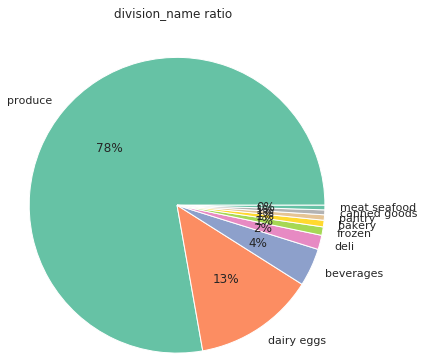

In [60]:
draw_pie_chart(base_df, 'division_name')

* 재구매건 차지 비중

  division_name   count      ratio
8       produce  857335  77.463427
3    dairy eggs  150937  13.637723
1     beverages   47899   4.327854
4          deli   17130   1.547760
5        frozen    9176   0.829086
0        bakery    8374   0.756622
7        pantry    5386   0.486645
2  canned goods    5306   0.479417
6  meat seafood    5218   0.471466


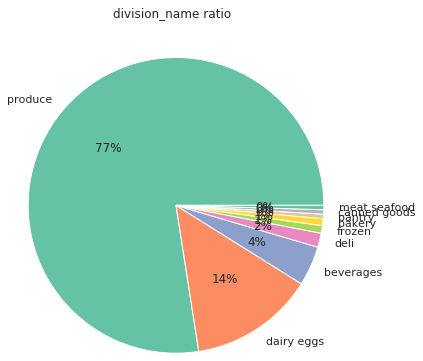

In [61]:
draw_pie_chart(base_df[base_df['is_reordered']==1], 'division_name')

### [13] 부서별 재구매율

> 부서 전반의 재구매율은 62% ~ 76% 사이임.

> 부서별로 재구매율을 따져 보았을때는, bakery 부서의 상품에 대한 재구매율이 가장 높음.


> 부서별로 재구매율을 따져 보았을때는, frozen 부서의 상품에 대한 재구매율이 가장 낮음.

In [66]:
dup_cols_1 = ['product_id','cstno','is_reordered','name','division_name']
dup_cols_2 = ['product_id','cstno','is_reordered']
by_col = 'division_name' 
final_x = calcul_reord_rate_dup(base_df, dup_cols_1, dup_cols_2, by_col)

In [67]:
def draw_pointplot(final_x, col) : 
    color = sns.color_palette()
    plt.figure(figsize=(10,8))
    sns.pointplot(final_x[col].values, final_x['order_ratio'].values, alpha=0.8, color=color[2])
    plt.ylabel('order_ratio', fontsize=10)
    plt.xlabel(col, fontsize=10)
    plt.title(col + " Reorder_ratio", fontsize=12)
    plt.xticks(rotation='vertical')
    plt.show()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


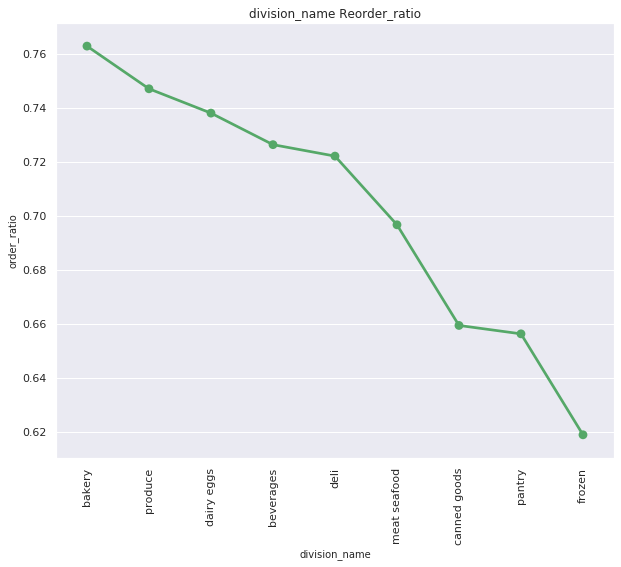

In [68]:
draw_pointplot(final_x, by_col)

In [69]:
del final_x 

### [14] 카테고리별 구매건 차지 비중

### fruits & vegtable 관련 카테고리 상품 구매건수가 75%로 압도적인 비중을 차지함.

* 구매건 차지 비중

                    category_name   count      ratio
6                    fresh fruits  511626  40.020932
8                fresh vegetables  288337  22.554592
16     packaged vegetables fruits  152901  11.960378
11                           milk   58377   4.566425
20  water seltzer sparkling water   42386   3.315561
13                packaged cheese   35974   2.813995
7                     fresh herbs   27506   2.151602
3                           cream   26977   2.110222
19                soy lactosefree   24181   1.891511
15               packaged produce   13966   1.092463
4                            eggs   13632   1.066336
5            fresh dips tapenades   13038   1.019872
9                  frozen produce   11735   0.917947
1                          butter   10172   0.795685
0                           bread    9247   0.723328
17                   refrigerated    7876   0.616085
12                  oils vinegars    7554   0.590897
10                     lunch meat    6939   0.

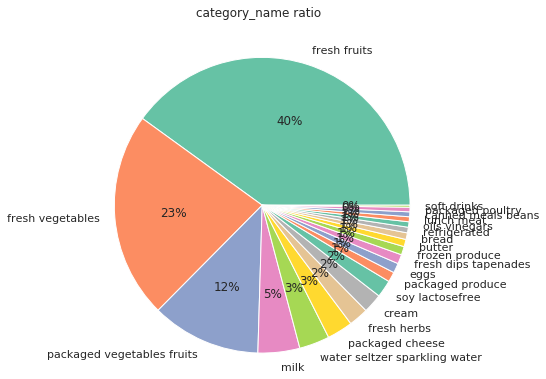

In [70]:
draw_pie_chart(base_df, 'category_name')

* 재구매건 차지 비중

                    category_name   count      ratio
6                    fresh fruits  457461  41.333314
8                fresh vegetables  235601  21.287432
16     packaged vegetables fruits  130821  11.820167
11                           milk   54336   4.909461
20  water seltzer sparkling water   38179   3.449616
13                packaged cheese   30501   2.755880
3                           cream   24340   2.199210
19                soy lactosefree   21535   1.945768
7                     fresh herbs   21416   1.935016
4                            eggs   12096   1.092919
15               packaged produce   12036   1.087498
5            fresh dips tapenades   11323   1.023075
9                  frozen produce    9176   0.829086
0                           bread    8374   0.756622
1                          butter    8129   0.734486
17                   refrigerated    7140   0.645126
10                     lunch meat    5807   0.524684
12                  oils vinegars    5386   0.

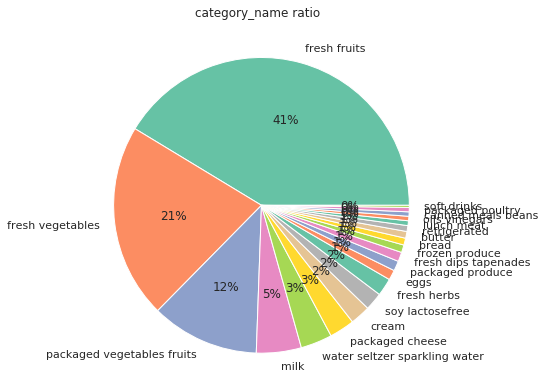

In [71]:
draw_pie_chart(base_df[base_df['is_reordered']==1], 'category_name')

### [15] 카테고리별 구매건 차지 비중

* 카테고리별로 재구매율은 62% ~ 78% 사이임.

* 카테고리별로 재구매율을 따져 보았을때는, fresh fruits 카테고리의 상품에 대한 재구매율이 가장 높음.

* 카테고리별 구매 상위 비중 항목과 다르게, milk, egg, bread 항목의 재구매율이 높게 나타남.

In [72]:
dup_cols_1 = ['product_id','cstno','is_reordered','name','category_name']
dup_cols_2 = ['product_id','cstno','is_reordered']
by_col = 'category_name' 
final_x = calcul_reord_rate_dup(base_df, dup_cols_1, dup_cols_2, by_col)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


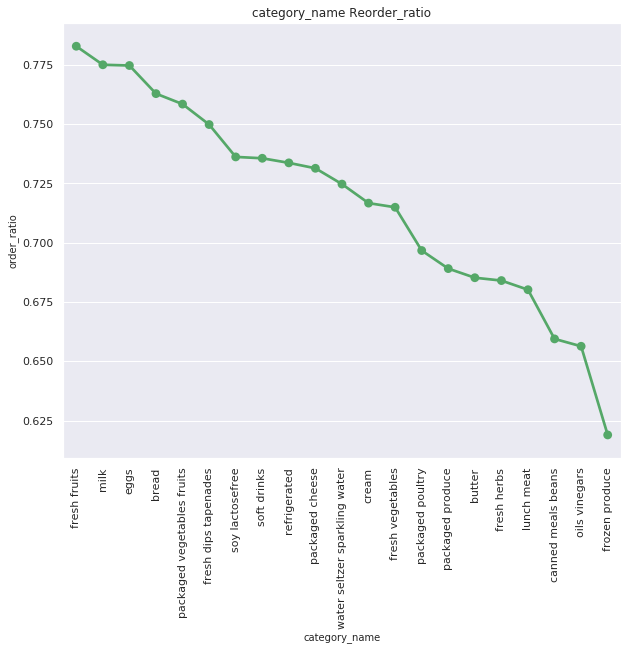

In [73]:
draw_pointplot(final_x, by_col)

### [16] 경과일수별 전체건수, 재구매건수 분포

### 재구매 비중 자체는 경과일수가 작을수록 적고, 전체 구매건수는 경과일수가 7일차일때 제일 건수가 많음 경과일수가 2주넘어가면 재구매 자체가 적음

In [74]:
def draw_reorder_barplot(df, col): 
    df_re_N =df[df['is_reordered'] == 1].groupby(col).count()['is_reordered']
    df_N =df.groupby(col).count()['is_reordered']
    N = len(df[col].unique())
    label = np.arange(N)
    index = np.arange(N)
    alpha = 0.5

    plt.figure(figsize=(10,5))
    p1 = plt.bar(index, df_N, color='r', alpha=alpha)
    p2 = plt.bar(index, df_re_N, color='b', alpha=alpha) 
    plt.title('Orders vs ' + col, fontsize=20)
    plt.ylabel('Count', fontsize=18)
    plt.xlabel(col, fontsize=18)
    plt.xticks(index, label, fontsize=15)
    plt.legend((p1[0], p2[0]), ('All Orderes', 'Reorders'), fontsize=15)
    plt.show()

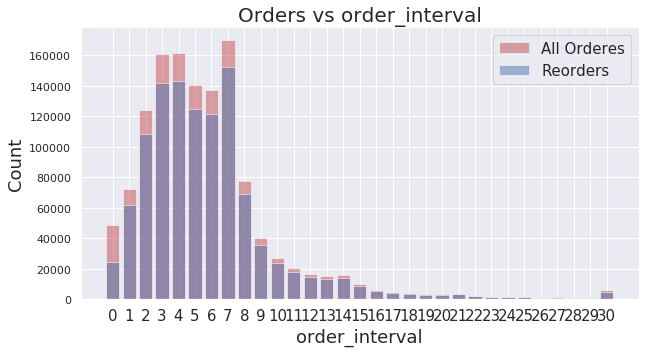

In [75]:
draw_reorder_barplot(base_df, 'order_interval')

* 경과일수가 짧은 Top20 상품

상품별로 구매하는 주기가 다를 것으로 판단하여, 상품별 경과일 수 확인 Whole Milk, soda 와 같은 상품의 구매주기가 짧은 것으로 확인

In [76]:
x_data = base_df.groupby(['product_id', 'name'])['order_interval'].mean()
x_data = x_data.reset_index(name='order_interval')
x_data = x_data.sort_values(by='order_interval', ascending=True)
x_data

product_id                                         name  order_interval
64       4210                                   Whole Milk        5.154860
10        196                                         Soda        5.171024
44      31506                       Extra Virgin Olive Oil        5.354647
5       16759                         Organic Carrot Bunch        5.373902
49      34126                Organic Italian Parsley Bunch        5.404978
..        ...                                          ...             ...
95       8424                               Broccoli Crown        6.066278
43      30489                              Original Hummus        6.071023
87      49683                               Cucumber Kirby        6.088427
8       18465  Organic Grade A Free Range Large Brown Eggs        6.122686
65      42265                         Organic Baby Carrots        6.189816

[100 rows x 3 columns]

<function matplotlib.pyplot.show(*args, **kw)>

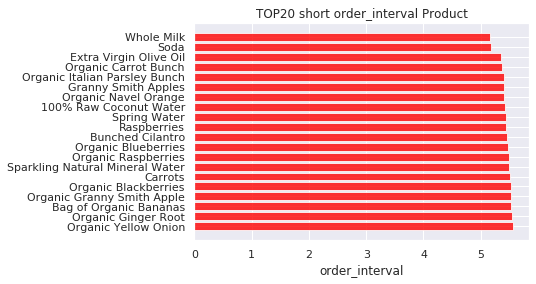

In [77]:
x_data = x_data.head(20)
plt.barh(x_data['name'],x_data['order_interval'], align='center', alpha=0.8, color='red')
plt.xlabel('order_interval')
plt.title('TOP20 short order_interval Product')
plt.gca().invert_yaxis()
plt.show

In [78]:
del x_data 

### [17] 요일별 전체건수, 재구매건수 분포

전체 구매건수는 일요일, 월요일에 제일 많고, 재구매 비중자체는 의외로 평일에 많았음

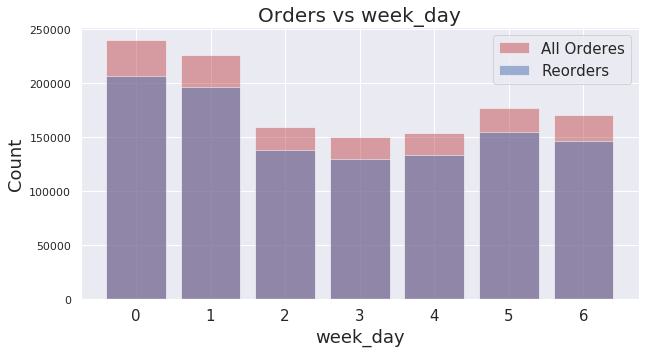

In [79]:
draw_reorder_barplot(base_df, 'week_day')

### [18] 시간별 전체건수, 재구매건수 분포

전체 건수는 오전 9시 ~ 오후 4시에 치우쳐져 있고, 재구매 비중 자체는 늦은 저녁(오후 7시 이후)부터 새벽에 많았음

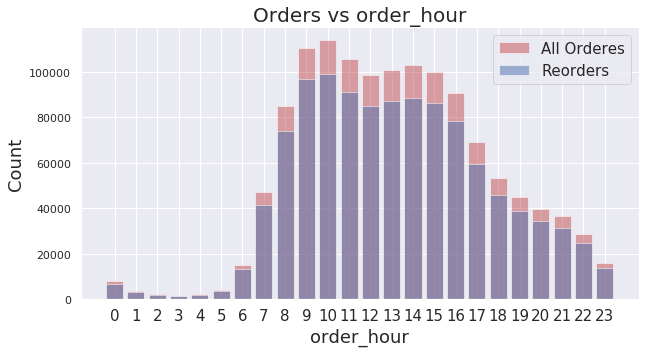

In [80]:
draw_reorder_barplot(base_df, 'order_hour')

### [19] 시간별 요일별 구매건 Heatmap

앞서 위에서 단일 그래프로 본 내용을 히트맵으로 구성

일자, 요일별 구매건수의 고저를 시각화

마찬가지로 일요일,월요일에 높은 구매건.. 일요일은 오전오후 고루 높게 분포, 월요일은 오전에 높은 구매건을 보임

In [81]:
base_df_v2 = base_df[['order_id','order_hour','week_day', 'is_reordered', 'cstno']].copy() # 히트맵에 필요한 컬럼 로딩

# 요일별 시간별 구매건수 확인
week_dict = {'0':'Sun'
            , '1':'Mon'
            , '2':'Tue'
            , '3':'Wed'
            , '4':'Thu' 
            , '5':'Fri'
            , '6':'Sat'}

def searchDict(val, dct) :
    for ky in dct.keys() :
        if val in dct[ky] : 
            return ky
    return np.nan

for ky in week_dict.keys() : 
    base_df_v2.loc[base_df['week_day'] == ky, 'week_day_adj'] = week_dict[ky]

In [82]:
df_weekhour = base_df_v2.pivot_table(index=['week_day', 'week_day_adj'], columns='order_hour', values='order_id', aggfunc=lambda x: len(x)/100).fillna(0)
df_weekhour

order_hour              0.0   1.0   2.0   3.0   4.0   5.0    6.0    7.0   \
week_day week_day_adj                                                      
0        Sun           15.00  8.13  3.76  3.16  3.62  5.08  17.58  72.94   
1        Mon           12.48  5.62  3.12  2.24  3.78  7.89  30.47  91.99   
2        Tue           10.64  4.54  2.39  2.13  2.64  5.67  22.65  61.73   
3        Wed            9.11  3.96  2.95  1.56  2.27  5.45  19.78  57.18   
4        Thu            8.93  4.30  3.21  1.78  2.16  4.19  20.42  59.80   
5        Fri            9.68  4.68  2.30  2.34  3.86  6.67  24.29  67.29   
6        Sat           12.67  5.42  3.72  2.10  2.95  4.63  16.58  59.13   

order_hour               8.0     9.0   ...    14.0    15.0    16.0    17.0  \
week_day week_day_adj                  ...                                   
0        Sun           150.47  197.66  ...  205.98  193.47  179.49  129.46   
1        Mon           171.97  235.02  ...  174.13  164.45  144.63  104.09   
2        Tue           103.68  142.95  ...  123.30  120.99  110.30   87.98   
3        Wed            97.51  121.45  ...  118.30  120.06  106.58   87.37   
4        Thu            95.38  120.84  ...  117.04  116.41  113.08   87.64   
5        Fri           113.98  156.59  ...  146.44  137.99  130.73   99.64   
6        Sat           115.19  131.43  ...  142.59  144.20  123.22   94.08   

order_hour              18.0   19.0   20.0   21.0   22.0   23.0  
week_day week_day_adj                                            
0        Sun           94.96  84.50  82.90  75.91  56.60  28.49  
1        Mon           77.86  64.35  56.40  53.33  35.53  21.35  
2        Tue           71.53  57.33  49.36  43.57  33.48  19.56  
3        Wed           68.27  58.47  47.95  42.08  35.66  18.43  
4        Thu           70.36  63.47  56.60  52.10  42.55  22.79  
5        Fri           72.08  58.13  49.84  45.09  37.28  21.54  
6        Sat           75.91  62.10  54.48  52.01  43.26  27.66  

[7 rows x 24 columns]

In [83]:
def draw_heatmap_by_hour_day(df, title, color) :
    sns.set(style="whitegrid", palette="coolwarm", font_scale=1, rc={'font.family':'NanumGothic'} )
    plt.figure(figsize=(20,6))
    f = sns.heatmap(df, annot=True, fmt=".3f", linewidths=.5, cmap=color) 
    plt.xlabel("Hour")
    plt.ylabel("Weekday")

    # 히트맵 잘림현상 방지위한 스크립트
    button, top = f.get_ylim()
    print(button, top)
    f.set_ylim(button+0.5, top-0.5)
    f.set_title(title, size = 15 )
    plt.show

6.5 0.5


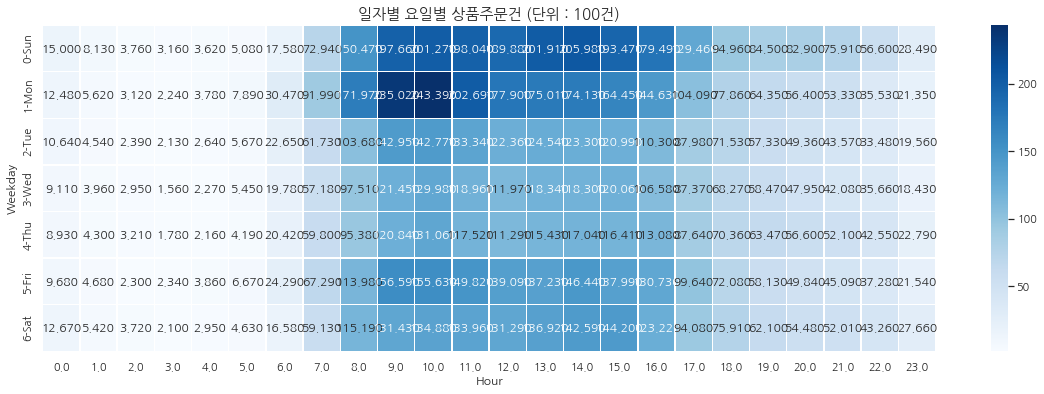

In [84]:
title = '일자별 요일별 상품주문건 (단위 : 100건)' 
draw_heatmap_by_hour_day(df_weekhour, title, 'Blues')

### [20] 시간별 요일별 재구매율 Heatmap

단순 구매건에 대한 히트맵말고 재구매율에 대한 분포 차이는 있는지 확인

전반적으로 0.8 이상의 재구매율을 보이기에.. 일자별 요일별로 각 큰 유의미한 차이를 보인다고 할 수 없다는 결론

In [85]:
base_df_v3 = base_df_v2.loc[base_df_v2['is_reordered']==1]
base_df_v3

order_id  order_hour week_day  is_reordered  cstno week_day_adj
0         999996        17.0        5             1  34552          Fri
1         999996        17.0        5             1  34552          Fri
2         999996        17.0        5             1  34552          Fri
3         999974         9.0        6             1  94872          Sat
4         999974         9.0        6             1  94872          Sat
...          ...         ...      ...           ...    ...          ...
1278391  1000003        19.0        5             1    444          Fri
1278392  1000003        19.0        5             1    444          Fri
1278393  1000003        19.0        5             1    444          Fri
1278394  1000003        19.0        5             1    444          Fri
1278395  1000003        19.0        5             1    444          Fri

[1106761 rows x 6 columns]

In [86]:
# 재구매한 얘들만 필터한 v3 df생성 후 테이블 조인
df_v2=base_df_v2.groupby(['order_hour','week_day_adj','week_day'])['order_id'].count()
df_v3=base_df_v3.groupby(['order_hour','week_day_adj','week_day'])['order_id'].count()

df_v2 = df_v2.reset_index()
df_v3 = df_v3.reset_index()
df_v2 = df_v2.sort_values(by=['order_hour','week_day_adj','week_day'])
df_v3 = df_v3.sort_values(by=['order_hour','week_day_adj','week_day'])
df_v2.rename(columns = {'order_id':'ratio'},inplace=True)
df_v3.rename(columns = {'order_id':'ratio'},inplace=True)

df_out = df_v3['ratio'].div(df_v2['ratio'])
df_out

0      0.836777
1      0.866987
2      0.823204
3      0.856667
4      0.870101
         ...   
163    0.860448
164    0.857845
165    0.848618
166    0.847648
167    0.850244
Name: ratio, Length: 168, dtype: float64

In [87]:
df_v4 = pd.concat([df_v3, df_out],axis=1)
df_v4_ = df_v4.loc[:,~df_v4.columns.duplicated(keep='last')] 
df_v4_
df_v5 = df_v4_.pivot_table(index=['week_day', 'week_day_adj'], columns='order_hour', values='ratio')
df_v5

order_hour                 0.0       1.0       2.0       3.0       4.0   \
week_day week_day_adj                                                     
0        Sun           0.856667  0.841328  0.893617  0.876582  0.870166   
1        Mon           0.866987  0.905694  0.858974  0.906250  0.854497   
2        Tue           0.854323  0.874449  0.878661  0.854460  0.859848   
3        Wed           0.841932  0.851010  0.810169  0.826923  0.876652   
4        Thu           0.870101  0.830233  0.897196  0.808989  0.888889   
5        Fri           0.836777  0.822650  0.843478  0.893162  0.893782   
6        Sat           0.823204  0.848708  0.873656  0.804762  0.803390   

order_hour                 5.0       6.0       7.0       8.0       9.0   ...  \
week_day week_day_adj                                                    ...   
0        Sun           0.875984  0.877702  0.867699  0.864225  0.864211  ...   
1        Mon           0.869455  0.883164  0.885966  0.875909  0.881627  ...   
2        Tue           0.892416  0.880353  0.876235  0.879630  0.872543  ...   
3        Wed           0.831193  0.845804  0.878454  0.879602  0.873281  ...   
4        Thu           0.875895  0.855044  0.881438  0.873663  0.871897  ...   
5        Fri           0.895052  0.877727  0.876356  0.877698  0.881410  ...   
6        Sat           0.846652  0.867913  0.860815  0.868825  0.869132  ...   

order_hour                 14.0      15.0      16.0      17.0      18.0  \
week_day week_day_adj                                                     
0        Sun           0.857850  0.857239  0.858154  0.850224  0.863311   
1        Mon           0.862689  0.866707  0.856876  0.858584  0.854739   
2        Tue           0.854988  0.863956  0.862375  0.876790  0.870823   
3        Wed           0.856382  0.867899  0.860105  0.868261  0.870368   
4        Thu           0.864064  0.868053  0.860630  0.872204  0.868675   
5        Fri           0.871825  0.874774  0.880288  0.865717  0.875555   
6        Sat           0.866260  0.857351  0.850917  0.862351  0.862469   

order_hour                 19.0      20.0      21.0      22.0      23.0  
week_day week_day_adj                                                    
0        Sun           0.865799  0.861158  0.866684  0.872261  0.857845  
1        Mon           0.872416  0.864894  0.864617  0.860681  0.858548  
2        Tue           0.861329  0.850081  0.864127  0.850358  0.847648  
3        Wed           0.872413  0.860271  0.858127  0.867919  0.850244  
4        Thu           0.868127  0.867491  0.857198  0.857814  0.848618  
5        Fri           0.860485  0.870987  0.864271  0.861588  0.855617  
6        Sat           0.855556  0.855176  0.852336  0.868007  0.860448  

[7 rows x 24 columns]

6.5 0.5


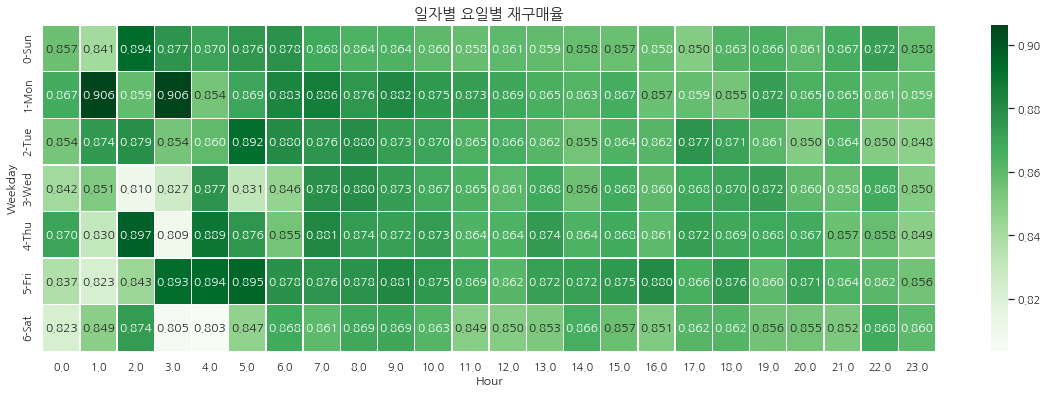

In [88]:
title = '일자별 요일별 재구매율'
draw_heatmap_by_hour_day(df_v5, title, 'Greens')

### [21] 시간별 요일별 고객별 주문건수 Heatmap

단순히 특정요일 및 시간에 고객수가 많아서 전체구매건이 많은 것은 아닐까라는 의문으로 고객별 평균 주문건수를 도식화

전체구매건이 많은 시점에 평균 고객당 주문건수도 많기에, 단순히 고객이 많아 주문건수가 많다고 볼 수 없었음

월요일, 일요일 정오부근 시점에 실질적인 주문이 많이 발생된다.

요일 및 시간이라는 변수로 고객 특성을 파악, 직전구매요일이라는 변수가 있다면 좀더 유의미한 모델을 만들 수 있지 않을까 생각

In [89]:
df_cstno_order = base_df_v2.pivot_table(index=['week_day', 'week_day_adj'], columns='order_hour', values='cstno', aggfunc=lambda x: round(len(x)/len(x.unique()),2)).fillna(0)
df_cstno_order

order_hour             0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   \
week_day week_day_adj                                                         
0        Sun           5.03  4.96  4.27  4.39  5.10  4.38  5.26  6.35  7.25   
1        Mon           4.66  4.36  3.76  4.39  4.67  5.52  5.72  6.76  7.83   
2        Tue           4.63  4.32  3.79  4.02  3.83  3.91  4.93  5.15  5.69   
3        Wed           4.05  4.21  3.99  3.47  3.55  3.84  4.50  5.11  5.48   
4        Thu           4.06  3.68  4.06  3.42  3.54  4.15  4.58  5.10  5.40   
5        Fri           4.15  4.11  3.59  4.33  5.08  4.76  5.32  5.62  5.98   
6        Sat           4.95  4.55  4.43  3.75  4.47  4.21  5.20  5.95  6.58   

order_hour             9.0   ...  14.0  15.0  16.0  17.0  18.0  19.0  20.0  \
week_day week_day_adj        ...                                             
0        Sun           7.94  ...  7.23  6.88  6.90  5.82  5.27  5.41  5.82   
1        Mon           8.59  ...  6.23  6.19  5.73  5.06  4.77  4.49  4.70   
2        Tue           6.03  ...  5.20  5.14  4.90  4.56  4.42  4.37  4.37   
3        Wed           5.69  ...  4.98  5.11  4.94  4.51  4.30  4.39  4.38   
4        Thu           5.62  ...  5.14  4.94  4.94  4.64  4.49  4.58  5.07   
5        Fri           6.60  ...  5.84  5.63  5.74  5.30  4.79  4.75  5.09   
6        Sat           6.40  ...  6.02  6.06  5.73  5.26  4.95  4.80  5.21   

order_hour             21.0  22.0  23.0  
week_day week_day_adj                    
0        Sun           6.24  6.23  5.38  
1        Mon           5.15  4.74  4.78  
2        Tue           4.88  4.68  4.42  
3        Wed           4.76  4.92  4.61  
4        Thu           5.34  5.41  4.55  
5        Fri           5.86  5.93  5.54  
6        Sat           5.70  5.59  5.28  

[7 rows x 24 columns]

6.5 0.5


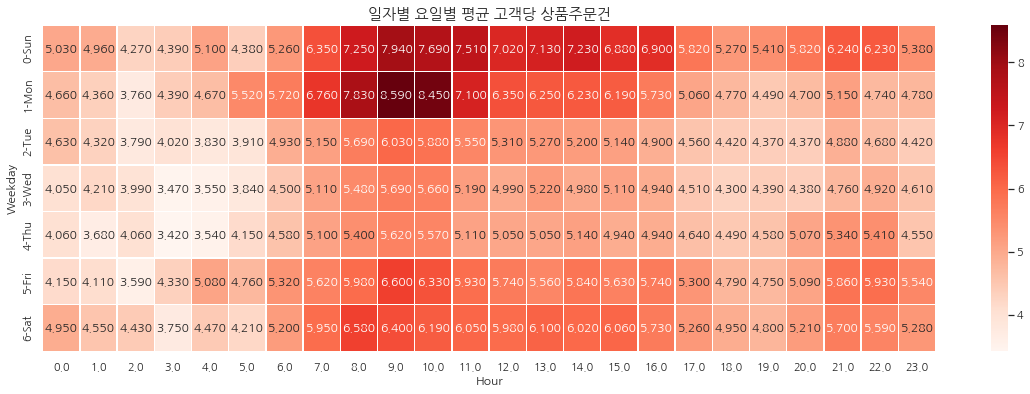

In [90]:
title = '일자별 요일별 평균 고객당 상품주문건'
draw_heatmap_by_hour_day(df_cstno_order, title, "Reds")

### [22] 부서별, 카테고리별 재구매건수 Treemap

부서별 & 카테고리별 재주문 건수 비중을 treemap으로 살펴본 결과, produce division의 재구매 비중이 가장 높고, dairy eggs, beverages 순

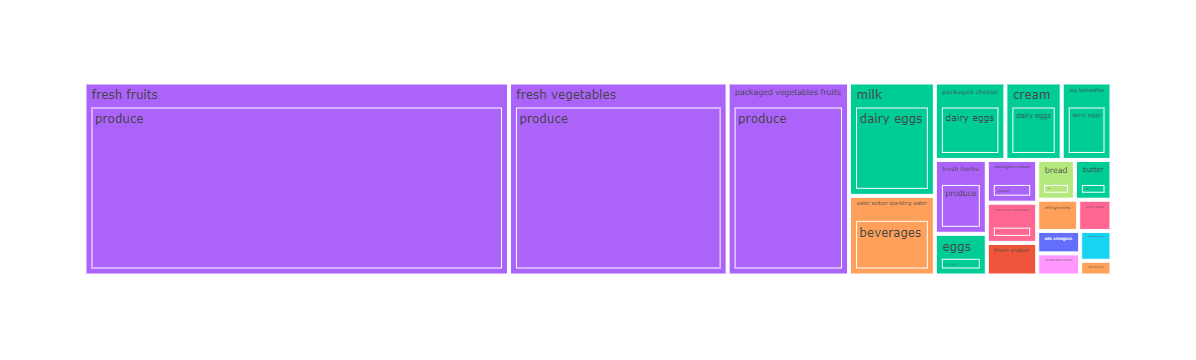

In [91]:
import plotly.express as px
fig = px.treemap(base_df, 
                 path=['category_name', 'division_name'], 
                 values='is_reordered', 
                 color = 'division_name'
                )
fig.show()

### 파생 변수 생성 함수

(1) 고객관점 파생변수, User level features

(2) 장바구니 순번별 특성 파생변수, add_order features

(3) 주문요일별 특성 파생변수, Week_day features

(4) 주문시간별 특성 파생변수, Order hour features

(5) EDA insight : 주문요일, 시간에 따른 클러스터 정보 생성, week_day, order_hour : cluster

(6) EDA insight : 주문건수가 많았던 organic 여부에 따라 cluster 생성

(7) 카테고리 정보로 pca 후 클러스터 정보 추출

* User level features

In [14]:
def make_user_feats(df) : 
    user_feats = pd.DataFrame()
    # mode_week_day : 고객별 구매요일 최빈값 
    # mode_order_hour : 고객별 구매시각 최빈값 
    # avg_order_interval : 고객별 경과일수 평균 
    # std_order_interval : 고객별 경과일수 표준편차
    # total_orders_by_user : 고객별 주문건수 
    # total_products_by_user : 고객별 주문 상품수 
    # total_unique_product_by_user : 고객별 주문 상품 unique 개수 
    # total_reorders_by_user : 고객별 재주문 상품 수
    # reorder_propotion_by_user : 고객별 재주문율 
    # mode_prod_id : 고객별 가장 많이 구매한 상품 
    user_feats[['cstno','mode_week_day']] = df.groupby('cstno')['week_day'].agg(lambda x :x.value_counts().index[0]).reset_index()
    user_feats['mode_order_hour'] = df.groupby('cstno')['order_hour'].agg(lambda x :x.value_counts().index[0]).reset_index()['order_hour']
    user_feats['avg_order_interval'] = df.groupby('cstno')['order_interval'].agg('mean').reset_index()['order_interval']
    user_feats['std_order_interval'] = df.groupby('cstno')['order_interval'].agg('std').reset_index()['order_interval']
    user_feats['total_orders_by_user'] = df.groupby('cstno')['order_number'].agg(lambda x: x.nunique()).reset_index()['order_number']
    user_feats['total_products_by_user'] = df.groupby('cstno')['product_id'].agg('count').reset_index()['product_id']
    user_feats['total_unique_product_by_user'] = df.groupby('cstno')['product_id'].agg(lambda x: x.nunique()).reset_index()['product_id']
    user_feats['total_reorders_by_user'] = df.groupby('cstno')['is_reordered'].agg('sum').reset_index()['is_reordered']
    user_feats['reorder_propotion_by_user'] = df.groupby('cstno')['is_reordered'].agg('mean').reset_index()['is_reordered']
    user_feats['mode_prod_id'] = df.groupby('cstno')['product_id'].agg(lambda x :x.value_counts().index[0]).reset_index()['product_id']

    # average_order_size : 고객별 평균 주문 건수
    # reorder_in_order : 고객별 주문당 평균 재주문율 
    user_feats2 = pd.DataFrame()
    user_feats2[['cstno', 'order_number', 'average_order_size']] = df.groupby(['cstno', 'order_number'])['is_reordered'].agg('count').reset_index()
    user_feats2['reorder_in_order'] = df.groupby(['cstno', 'order_number'])['is_reordered'].agg('mean').reset_index()['is_reordered']
    user_feats2['add_order'] = df.groupby(['cstno', 'order_number'])['add_order'].agg('min').reset_index()['add_order'] 
    user_feats3 = user_feats2.groupby('cstno').agg({'average_order_size' : 'mean', 'reorder_in_order' : 'mean'})
    user_feats3 = user_feats3.reset_index()
    user_feats = user_feats.merge(user_feats3, on = 'cstno', how = 'left')
    
    # orders_1 : 직전 구매 주문건의 평균 주문 사이즈
    # orders_2 : 2번째 이전 구매 주문건의 평균 주문 사이즈
    # orders_3 : 3번째 이전 구매 주문건의 평균 주문 사이즈
    # orders_1 : 직전 구매 주문건의 평균 주문 사이즈
    # orders_2 : 2번째 이전 구매 주문건의 평균 주문 사이즈
    # orders_3 : 3번째 이전 구매 주문건의 평균 주문 사이즈
    # prod_1 : 직전 구매 주문건의 처음 장바구니에 담은 상품
    # prod_2 : 2번째 이전 구매 주문건의 처음 장바구니에 담은 상품
    # prod_3 : 3번째 이전 구매 주문건의 처음 장바구니에 담은 상품
    # cate_1 : 직전 구매 주문건의 처음 장바구니에 담은 상품의 카테고리 정보
    # cate_2 : 2번째 이전 구매 주문건의 처음 장바구니에 담은 상품의 카테고리 정보
    # cate_3 : 3번째 이전 구매 주문건의 처음 장바구니에 담은 상품의 카테고리 정보 
    # reorder_1 : 직전 구매 주문건의 재주문비율
    # reorder_2 : 2번째 이전 구매 주문건의 재주문비율
    # reorder_3 : 3번째 이전 구매 주문건의 재주문비율 
    last_three_orders = user_feats2.groupby('cstno')['order_number'].nlargest(3).reset_index()
    last_three_orders = user_feats2.merge(last_three_orders, on = ['cstno', 'order_number'], how = 'inner')
    last_three_orders['rank'] = last_three_orders.groupby("cstno")["order_number"].rank("dense", ascending=True)
    last_three_orders = last_three_orders.merge(df[['cstno', 'order_number', 'add_order', 'category_id', 'division_id', 'product_id']], on = ['cstno', 'order_number', 'add_order'], how = 'inner')
    last_three_orders=last_three_orders.astype({'category_id':'int', 'division_id':'int', 'product_id':'int'})
    last_order_feats = last_three_orders.pivot_table(index = 'cstno', columns = ['rank'], values=['average_order_size', 'reorder_in_order', 'category_id', 'division_id', 'product_id']).reset_index(drop = False)
    last_order_feats.columns = ['cstno' ,'orders_3', 'orders_2', 'orders_1' ,'cate_3', 'cate_2', 'cate_1' ,'divi_3', 'divi_2', 'divi_1' ,'prod_3', 'prod_2', 'prod_1' ,'reorder_3', 'reorder_2', 'reorder_1']
    user_feats = user_feats.merge(last_order_feats, on = 'cstno', how = 'left')

    # user_prod_reord_prop : 고객별 상품별 재주문율
    # user_uniqpr : 고객이 주문한 상품 unique개수 
    # user_uniqpr_prop : 전체 주문한 상품들 중 unique한 상품들의 비중 
    # user_order_reord_prop : 고객별 전체 주문건내 재주문건이 포함된 것들의 비율  
    # user_max_order_size : 각 고객별 주문건 내 최대 상품 수 
    user_max_ono = df.groupby(['cstno']).agg({'order_number':max}).reset_index()
    user_max_ono.columns=['cstno','user_max_ono']
    user_prod_reord_prop=df.groupby(['cstno','product_id']).agg({'is_reordered':sum}).reset_index()
    user_prod_reord_prop['is_reordered']=user_prod_reord_prop['is_reordered'].apply(lambda x: 1 if x>0 else 0)
    user_prod_reord_prop=user_prod_reord_prop.groupby(['cstno']).agg({'product_id':'count','is_reordered':sum}).reset_index()
    user_prod_reord_prop['user_prod_reord_prop']=user_prod_reord_prop['is_reordered']/user_prod_reord_prop['product_id']
    user_prod_reord_prop.drop(['product_id','is_reordered'],axis=1,inplace=True)

    user_uniqpr=df.groupby(['cstno']).agg({'product_id':'nunique'}).reset_index()
    user_uniqpr.columns=['cstno','user_uniq_pr']
    user_total_products=df.groupby(['cstno']).agg({'product_id':'count'}).reset_index().product_id
    user_uniqpr_prop=pd.DataFrame(user_uniqpr)
    user_uniqpr_prop['total_products']=user_total_products
    user_uniqpr_prop['user_uniqpr_prop']=user_uniqpr_prop['user_uniq_pr']/user_uniqpr_prop['total_products']
    user_uniqpr_prop.drop(['user_uniq_pr','total_products'],axis=1,inplace=True)
        
    user_order_reord_prop=df.groupby(['cstno','order_number']).agg({'is_reordered':sum}).reset_index()
    user_order_reord_prop['is_reordered']=user_order_reord_prop['is_reordered'].apply(lambda x: 1 if x>0 else 0)
    user_order_reord_prop=user_order_reord_prop.groupby(['cstno']).agg({'order_number':'count','is_reordered':sum}).reset_index()
    user_order_reord_prop['user_order_reord_prop']=user_order_reord_prop['is_reordered']/user_order_reord_prop['order_number']
    user_order_reord_prop.drop(['order_number','is_reordered'],axis=1,inplace=True)

    user_order_sizes=df.groupby(['cstno','order_number']).agg({'product_id':'count'}).reset_index()
    user_max_order_size=user_order_sizes.groupby(['cstno']).agg({'product_id':max}).reset_index()
    user_max_order_size.columns=['csnto','user_max_order_size']
    user_mean_order_size=user_order_sizes.groupby(['cstno']).agg({'product_id':'mean'}).reset_index()
    user_features=pd.DataFrame({'cstno':user_max_ono.cstno,
                               'user_prod_reord_prop':user_prod_reord_prop.user_prod_reord_prop,
                               'user_uniqpr_prop':user_uniqpr_prop.user_uniqpr_prop,
                               'user_order_reord_prop':user_order_reord_prop.user_order_reord_prop,
                               'user_max_order_size':user_max_order_size.user_max_order_size})
    user_feats = user_feats.merge(user_features, on = 'cstno', how = 'inner')
    
    return user_feats

* x_train_past 데이터로 고객관점 파생변수 생성

In [94]:
prior_df = base_df[base_df['is_past_current'] == 'past']
user_feats = make_user_feats(df = prior_df)

In [15]:
def make_add_order_feats(df) : 
    # add_order_reordered : 주문순번별 재주문 건수
    # add_order_reordered_prop : 주문순번별 재주문율
    add_order_reordered=df.groupby(['add_order']).agg({'is_reordered':sum}).reset_index()
    add_order_reordered.columns=['add_order','add_order_reordered']
    add_order_reordered

    
    add_order_reordered_prop=pd.DataFrame(add_order_reordered)
    add_order_reordered_cnt=df.groupby(['add_order']).agg({'is_reordered':'count'}).reset_index().is_reordered
    add_order_reordered_prop['add_order_reordered_cnt']=add_order_reordered_cnt
    add_order_reordered_prop['add_order_reordered_prop']=add_order_reordered_prop['add_order_reordered']/add_order_reordered_prop['add_order_reordered_cnt']
    add_order_reordered_prop.drop(['add_order_reordered','add_order_reordered_cnt'],axis=1,inplace=True)
    add_order_reordered_prop

    
    add_order_features=pd.DataFrame({'add_order':add_order_reordered.add_order,
                              'add_order_reordered':add_order_reordered.add_order_reordered,
                               'add_order_reordered_prop':add_order_reordered_prop.add_order_reordered_prop
                              })
    return add_order_features

* x_train_past 데이터로 주문 순번 관점 파생변수 생성

In [96]:
atc_features = make_add_order_feats(df = prior_df)

In [24]:
def make_weekday_feats(df) : 
    # week_day_reordered : 주문 요일별 재주문 건수
    # week_day_reordered_prop : 주문 요일별 재주문율
    week_day_reordered=df.groupby('week_day').agg({'is_reordered':sum}).reset_index()
    week_day_reordered.columns=['week_day','week_day_reordered']

    week_day_reordered_prop=pd.DataFrame(week_day_reordered)
    week_day_reordered_prop['total_purchases']=df.groupby('week_day').agg({'is_reordered':'count'}).reset_index().is_reordered
    week_day_reordered_prop['week_day_reordered_prop']=week_day_reordered_prop['week_day_reordered']/week_day_reordered_prop['total_purchases']
    week_day_reordered_prop.drop(['week_day_reordered','total_purchases'],axis=1,inplace=True)

    week_day_features=pd.DataFrame({'week_day':week_day_reordered_prop.week_day,
                                     'week_day_reordered':week_day_reordered.week_day_reordered,
                                     'week_day_reordered_prop':week_day_reordered_prop.week_day_reordered_prop
                                    })
    return week_day_features

* x_train_past 데이터로 주문 요일 관점 파생변수 생성

In [98]:
week_day_features = make_weekday_feats(prior_df)

In [17]:
def make_order_hours_feats(df) : 
    # order_hour_reordered : 주문 시간별 재주문건수
    # order_hour_reordered_prop : 주문 시간별 재주문율
    order_hour_reordered=df.groupby('order_hour').agg({'is_reordered':sum}).reset_index()
    order_hour_reordered.columns=['order_hour','order_hour_reordered']

    order_hour_reordered_prop=pd.DataFrame(order_hour_reordered)
    order_hour_reordered_prop['total_purchases']=df.groupby('order_hour').agg({'is_reordered':'count'}).reset_index().is_reordered
    order_hour_reordered_prop['order_hour_reordered_prop']=order_hour_reordered_prop['order_hour_reordered']/order_hour_reordered_prop['total_purchases']
    order_hour_reordered_prop.drop(['order_hour_reordered','total_purchases'],axis=1,inplace=True)

    order_hour_features=pd.DataFrame({'order_hour':order_hour_reordered_prop.order_hour,
                                     'order_hour_reordered':order_hour_reordered.order_hour_reordered,
                                     'order_hour_reordered_prop':order_hour_reordered_prop.order_hour_reordered_prop
                                    })
    return order_hour_features

* x_train_past 데이터로 주문 시간 관점 파생변수 생성

In [100]:
order_hour_features = make_order_hours_feats(prior_df)


### week_day, order_hour : cluster

EDA 결과를 보고 주문건수가 패턴이 비슷했던 요일, 시점 정보를 짤라 하나의 범주형 변수(conditions)를 cluster 정보로 만듬

In [18]:
def make_hour_weekday_cluster(df) :
    res_df = df.copy()
    res_df['week_day'] = res_df['week_day'].astype('int')
    res_df['order_hour'] = res_df['order_hour'].astype('int')

    conditions = [
        (res_df.week_day < 2) & (res_df.order_hour < 7),
        (res_df.week_day < 2) & (res_df.order_hour >= 7) & (res_df.order_hour < 18),
        (res_df.week_day < 2) & (res_df.order_hour >= 18),
        (res_df.week_day >= 2 ) & (res_df.week_day < 5 ) & (res_df.order_hour < 7),
        (res_df.week_day >= 2 ) & (res_df.week_day < 5 ) & (res_df.order_hour >= 7) & (res_df.order_hour < 18),
        (res_df.week_day >= 2 ) & (res_df.week_day < 5 ) & (res_df.order_hour >= 18),
        (res_df.week_day >= 5 ) & (res_df.order_hour < 7),
        (res_df.week_day >= 5 ) & (res_df.order_hour >= 7) & (res_df.order_hour < 18),
        (res_df.week_day >= 5 ) & (res_df.order_hour >= 18)
    ]

    vals = ['1', '2', '3', '4','5','6','7','8','9']
    
    res_df['hour_weekday_cluster'] = np.select(conditions, vals)
    
    res_df['week_day'] = res_df['week_day'].astype('object')
    res_df['order_hour'] = res_df['order_hour'].astype('object')
    return res_df

In [19]:
def make_hour_weekday_cluster_feats(df) : 
    # hour_weekday_cluster_reord_count : clulster별 재주문건수
    # hour_weekday_cluster_reord_prop : clulster별 재주문율
    hour_weekday_cluster_reord_count=df.groupby(['hour_weekday_cluster']).agg({'is_reordered':sum}).reset_index()
    hour_weekday_cluster_reord_count.columns=['hour_weekday_cluster','hour_weekday_cluster_reord_count']

    hour_weekday_cluster_reord_prop=pd.DataFrame(hour_weekday_cluster_reord_count)
    hour_weekday_cluster_reord_prop['hour_weekday_cluster_reord_cnt']= df.groupby(['hour_weekday_cluster']).agg({'is_reordered':'count'}).reset_index().is_reordered
    hour_weekday_cluster_reord_prop['hour_weekday_cluster_reord_prop']=hour_weekday_cluster_reord_prop['hour_weekday_cluster_reord_count']/hour_weekday_cluster_reord_prop['hour_weekday_cluster_reord_cnt']
    hour_weekday_cluster_reord_prop.drop(['hour_weekday_cluster_reord_count','hour_weekday_cluster_reord_cnt'],axis=1,inplace=True)

    hour_weekday_cluster_features=pd.DataFrame({'hour_weekday_cluster':hour_weekday_cluster_reord_count.hour_weekday_cluster, 
                                        'hour_weekday_cluster_reord_count':hour_weekday_cluster_reord_count.hour_weekday_cluster_reord_count,
                                         'hour_weekday_cluster_reord_prop':hour_weekday_cluster_reord_prop.hour_weekday_cluster_reord_prop
                                        })
    return hour_weekday_cluster_features

In [103]:
prior_df_v2 = make_hour_weekday_cluster(prior_df)
hour_weekday_cluster_features = make_hour_weekday_cluster_feats(prior_df_v2)

##### 상품을 카테고리별 , Organic 상품 여부별로 묶음. 

- 추후 ML 모델에 넣는 과정에서 Onehot 인코딩 과정을 수행하는데, 이때 항목이 다양한 경우 컬럼수가 너무 많아짐.
- EDA 결과 Oragin 재품의 구매 및 재구매 비중이 높음을 확인했음으로, 카테고리를 Organic 상품여부로 세분화함. 

In [20]:
def category_class(df) : 
    s1 = df.loc[:,['category_name', 'name','product_id']]
    s1['Temp'] = s1['name'].str.contains('Organic', case=False)
    s1.loc[s1['Temp'] == True, 'is_organic'] = 'OG'
    s1.loc[s1['Temp'] == False, 'is_organic'] = 'NOG'
    s1['for_label'] = s1['category_name'] + s1['is_organic']
    s1.reset_index(drop =True, inplace = True)

    le = LabelEncoder()
    le.fit(s1['for_label'])
    le_encoded = le.transform(s1['for_label'])
    Category_og = pd.DataFrame(le_encoded, columns = ['category_class'])
    category_class = pd.concat([s1,Category_og], axis=1)
    category_class = category_class.loc[:,['product_id','category_class']]

    category_class.drop_duplicates(inplace = True)
    category_class_c = category_class.astype({'product_id': np.int32})
    return category_class_c

In [105]:
category_class_features = category_class(prior_df)

In [106]:
category_class_features

product_id  category_class
0          49683              12
1          18465               6
2          24852               8
3          26209               8
4          21616              25
...          ...             ...
626        31506              19
654        41787               8
981        47144              28
1057       27344              16
1436       28199              24

[100 rows x 2 columns]

### 카테고리 정보로 pca 후 클러스터링 시행

In [21]:
def run_pca(df, N_compo=10) :
    cross_df = pd.crosstab(df.cstno, df.category_name)
    df = cross_df.div(cross_df.sum(axis=1), axis=0)
    pca = PCA(n_components=N_compo) 
    df_pca = pca.fit_transform(df) 
    df_pca = pd.DataFrame(df_pca) 
    return df_pca, cross_df

In [108]:
pca_df,cross_df = run_pca(prior_df)

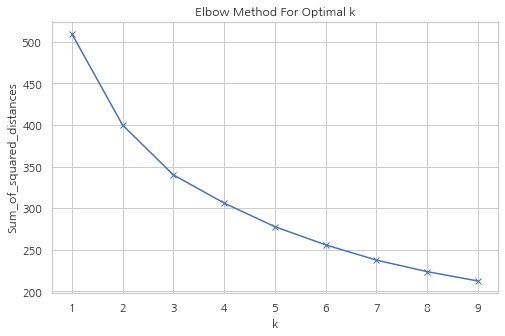

In [109]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_df)
    Sum_of_squared_distances.append(km.inertia_)
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [22]:
def run_kmeans(pca_df, cross_df) : 
    clusterer = KMeans(n_clusters=3,random_state=42).fit(pca_df)
    centers = clusterer.cluster_centers_
    c_preds = clusterer.predict(pca_df)
    temp_df = pca_df.iloc[:, 0:2] 
    temp_df.columns = ["pc1", "pc2"] 
    temp_df['cluster'] = c_preds
    fig, ax = plt.subplots(figsize = (8, 5))
    ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title("Cluster Visualization")
    plt.show();
    cross_df['cluster'] = c_preds
    aa = cross_df.iloc[:,-1:]
    aa = aa.reset_index()
    return aa

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 8722 missing from current font.

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 8722 missing from current font.



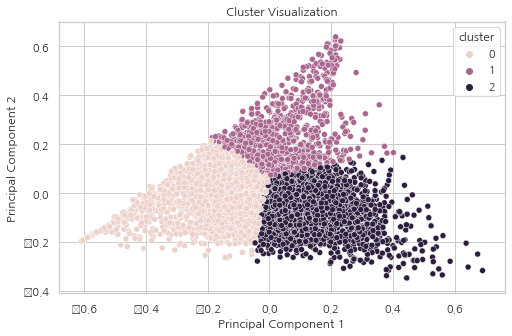

In [111]:
Kluster_Info = run_kmeans(pca_df, cross_df)

In [112]:
Kluster_Info

category_name   cstno  cluster
0               10000        2
1              100001        2
2              100046        2
3              100071        2
4              100108        0
...               ...      ...
5854             9981        1
5855            99829        2
5856            99887        2
5857            99894        1
5858            99901        1

[5859 rows x 2 columns]

In [113]:
root = 'data/'
user_feats.to_pickle(root + 'user_features.pkl')
atc_features.to_pickle(root + 'atc_features.pkl')
week_day_features.to_pickle(root + 'week_day_features.pkl')
order_hour_features.to_pickle(root + 'order_hour_features.pkl')
hour_weekday_cluster_features.to_pickle(root + 'hour_weekday_cluster_features.pkl')
category_class_features.to_pickle(root + 'category_class_features.pkl')
Kluster_Info.to_pickle(root + 'Kluster_Info.pkl')

In [114]:
with open('data/user_features.pkl', 'rb') as f :
     user_feats = pickle.load(f)
with open('data/atc_features.pkl', 'rb') as f :
    atc_features = pickle.load(f)
with open('data/week_day_features.pkl', 'rb') as f :
    week_day_features = pickle.load(f)
with open('data/order_hour_features.pkl', 'rb') as f :
     order_hour_features = pickle.load(f)
with open('data/hour_weekday_cluster_features.pkl', 'rb') as f :
    hour_weekday_cluster_features = pickle.load(f)  
with open('data/category_class_features.pkl', 'rb') as f :
    category_class_features = pickle.load(f)  
with open('data/Kluster_Info.pkl', 'rb') as f :
    Kluster_Info = pickle.load(f)  

In [115]:
base_df = base_df.astype({'week_day':'int', 'division_id':'int', 'category_id':'int','order_hour':'int'})
week_day_features = week_day_features.astype({'week_day':'int'})

In [116]:
base_df_v2 = make_hour_weekday_cluster(base_df)
base_df_v2 = base_df_v2.merge(user_feats, on = 'cstno', how = 'left')
base_df_v2 = base_df_v2.merge(atc_features, on = 'add_order', how = 'left')
base_df_v2 = base_df_v2.merge(week_day_features, on = 'week_day', how = 'left')
base_df_v2 = base_df_v2.merge(order_hour_features, on = 'order_hour', how = 'left')
base_df_v2 = base_df_v2.merge(category_class_features, left_on = 'prod_1', right_on = 'product_id', how = 'left', suffixes=['','_prod_1'])
base_df_v2 = base_df_v2.merge(category_class_features, left_on = 'prod_2', right_on = 'product_id', how = 'left', suffixes=['','_prod_2']) 
base_df_v2 = base_df_v2.merge(category_class_features, left_on = 'prod_3', right_on = 'product_id', how = 'left', suffixes=['','_prod_3']) 
base_df_v2 = base_df_v2.astype({'mode_prod_id':'int'})
base_df_v2 = base_df_v2.merge(category_class_features, left_on = 'mode_prod_id', right_on = 'product_id', how = 'left', suffixes=['','_mode_prod_id']) 
base_df_v2 = base_df_v2.merge(hour_weekday_cluster_features, on = 'hour_weekday_cluster', how = 'left')
base_df_v2= base_df_v2.drop(['product_id_prod_1','product_id_prod_2','product_id_prod_3'], axis=1)
base_df_v2.rename(columns = {'category_class' : 'category_class_prod_1'}, inplace = True)
base_df_v2 = pd.merge(base_df_v2, Kluster_Info, on=['cstno'], how='left')

In [117]:
base_df_v2

order_id  cstno  order_number week_day order_hour  order_interval  \
0         999996  34552            14        5         17             5.0   
1         999996  34552            14        5         17             5.0   
2         999996  34552            14        5         17             5.0   
3         999974  94872            40        6          9             3.0   
4         999974  94872            40        6          9             3.0   
...          ...    ...           ...      ...        ...             ...   
1278391  1000003    444            32        5         19             7.0   
1278392  1000003    444            32        5         19             7.0   
1278393  1000003    444            32        5         19             7.0   
1278394  1000003    444            32        5         19             7.0   
1278395  1000003    444            32        5         19             7.0   

         add_order  is_reordered product_id  is_first_order  ...  \
0                1             1      49683               0  ...   
1                3             1      18465               0  ...   
2                8             1      24852               0  ...   
3                9             1      26209               0  ...   
4                1             1      21616               0  ...   
...            ...           ...        ...             ...  ...   
1278391         28             1      27966               0  ...   
1278392          4             1      24184               0  ...   
1278393          8             1      21938               0  ...   
1278394          7             1      45007               0  ...   
1278395         16             1      16797               0  ...   

        order_hour_reordered order_hour_reordered_prop  category_class_prod_1  \
0                      58283                  0.862060                     30   
1                      58283                  0.862060                     30   
2                      58283                  0.862060                     30   
3                      94788                  0.872753                      9   
4                      94788                  0.872753                      9   
...                      ...                       ...                    ...   
1278391                37977                  0.863761                      8   
1278392                37977                  0.863761                      8   
1278393                37977                  0.863761                      8   
1278394                37977                  0.863761                      8   
1278395                37977                  0.863761                      8   

         category_class_prod_2 category_class_prod_3 product_id_mode_prod_id  \
0                           12                     9                   35221   
1                           12                     9                   35221   
2                           12                     9                   35221   
3                           16                     9                   35951   
4                           16                     9                   35951   
...                        ...                   ...                     ...   
1278391                     25                     8                   24184   
1278392                     25                     8                   24184   
1278393                     25                     8                   24184   
1278394                     25                     8                   24184   
1278395                     25                     8                   24184   

        category_class_mode_prod_id hour_weekday_cluster_reord_count  \
0                                30                           235279   
1                                30                           235279   
2                                30                           235279   
3                                29         

In [118]:
x_train = base_df.loc[base_df['is_past_current']=='past',:]
y_train = x_train['product_id']
x_valid = base_df.loc[base_df['is_past_current']=='current',:]
y_valid = x_valid['product_id']

In [119]:
x_train= x_train.drop(['is_past_current','product_id'],axis=1 )
x_valid= x_valid.drop(['is_past_current','product_id'],axis=1 )

In [120]:
x_train.columns

Index(['order_id', 'cstno', 'order_number', 'week_day', 'order_hour',
       'order_interval', 'add_order', 'is_reordered', 'is_first_order', 'name',
       'category_id', 'division_id', 'category_name', 'division_name'],
      dtype='object')

### 데이터준비 (ONEHOT_ENCODING)

In [121]:
base_df = base_df_v2

base_df= base_df.drop(['order_id','cstno','order_number','week_day','order_hour','name','category_id',
                      'division_id', 'category_name', 'division_name', 'orders_3', 'orders_2', 'orders_1', 'cate_3',
                       'cate_2', 'cate_1', 'divi_3', 'divi_2', 'divi_1', 'prod_3', 'prod_2','prod_1', 'reorder_3', 'reorder_2', 
                       'reorder_1','product_id_mode_prod_id'], axis=1)

In [122]:
x_train = base_df.loc[base_df['is_past_current']=='past',:]
y_train = x_train['product_id']
x_valid = base_df.loc[base_df['is_past_current']=='current',:]
y_valid = x_valid['product_id']

x_train= x_train.drop(['is_past_current','product_id'],axis=1 )
x_valid= x_valid.drop(['is_past_current','product_id'],axis=1 )

In [123]:
num_feats = ['order_interval',  
'avg_order_interval', 'std_order_interval', 'total_orders_by_user',
'total_products_by_user', 'total_unique_product_by_user',
'total_reorders_by_user', 'reorder_propotion_by_user', 'mode_prod_id',
'average_order_size', 'reorder_in_order', 'user_prod_reord_prop',
'user_uniqpr_prop', 'user_order_reord_prop',
'user_max_order_size', 'add_order_reordered',
'add_order_reordered_prop', 'week_day_reordered', 'week_day_reordered_prop',
'order_hour_reordered', 'order_hour_reordered_prop',
'hour_weekday_cluster_reord_count', 'hour_weekday_cluster_reord_prop']

cate_feats = ['add_order','is_reordered', 'is_first_order', 'hour_weekday_cluster', 
'mode_week_day', 'mode_order_hour', 'category_class_prod_1', 'category_class_prod_2',
'category_class_prod_3', 'category_class_mode_prod_id', 'cluster']

In [124]:
ohe_x_train = pd.get_dummies(x_train, columns=cate_feats)
ohe_x_train
ohe_x_valid = pd.get_dummies(x_valid, columns=cate_feats)
ohe_x_valid

order_interval  avg_order_interval  std_order_interval  \
93                  7.0            7.142857            2.915653   
416                 4.0            6.168317            3.683872   
417                 4.0            6.168317            3.683872   
418                 4.0            6.168317            3.683872   
419                 4.0            6.168317            3.683872   
...                 ...                 ...                 ...   
1277510             6.0            7.541284            3.774996   
1277854             2.0            3.579268            2.508843   
1277940            13.0            5.533708            4.589535   
1277970             2.0            8.161290            3.450967   
1277971             2.0            8.161290            3.450967   

         total_orders_by_user  total_products_by_user  \
93                         44                      70   
416                        63                     303   
417                        63                     303   
418                        63                     303   
419                        63                     303   
...                       ...                     ...   
1277510                    45                     109   
1277854                    78                     164   
1277940                    52                     178   
1277970                    46                     310   
1277971                    46                     310   

         total_unique_product_by_user  total_reorders_by_user  \
93                                  9                      61   
416                                35                     268   
417                                35                     268   
418                                35                     268   
419                                35                     268   
...                               ...                     ...   
1277510                            10                      99   
1277854                            17                     147   
1277940                            27                     151   
1277970                            43                     267   
1277971                            43                     267   

         reorder_propotion_by_user  mode_prod_id  average_order_size  ...  \
93                        0.871429          5785            1.590909  ...   
416                       0.884488         27845            4.809524  ...   
417                       0.884488         27845            4.809524  ...   
418                       0.884488         27845            4.809524  ...   
419                       0.884488         27845            4.809524  ...   
...                            ...           ...                 ...  ...   
1277510                   0.908257         41220            2.422222  ...   
1277854                   0.896341         24852            2.102564  ...   
1277940                   0.848315         24852            3.423077  ...   
1277970                   0.861290         13176            6.739130  ...   
1277971                   0.861290         13176            6.739130  ...   

         category_class_mode_prod_id_24  category_class_mode_prod_id_25  \
93                                    0                               0   
416                                   0                               0   
417                                   0                               0   
418                                   0                               0   
419                                   0                               0   
...                                 ...                             ...   
1277510                               0                               0   
1277854                               0                               0   
1277940                               0                               0   
1277970                               0                        

In [125]:
set(ohe_x_valid.dtypes)

{dtype('uint8'), dtype('int64'), dtype('float64')}

# correlation plot을 그려 변수간 상관계수 파악  


In [126]:
import seaborn as sns

In [127]:
cor_df = x_train[num_feats].corr()

##### clustermap으로 유사한 변수끼리 묶어서 시각화해봄

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 8722 missing from current font.

/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 8722 missing from current font.



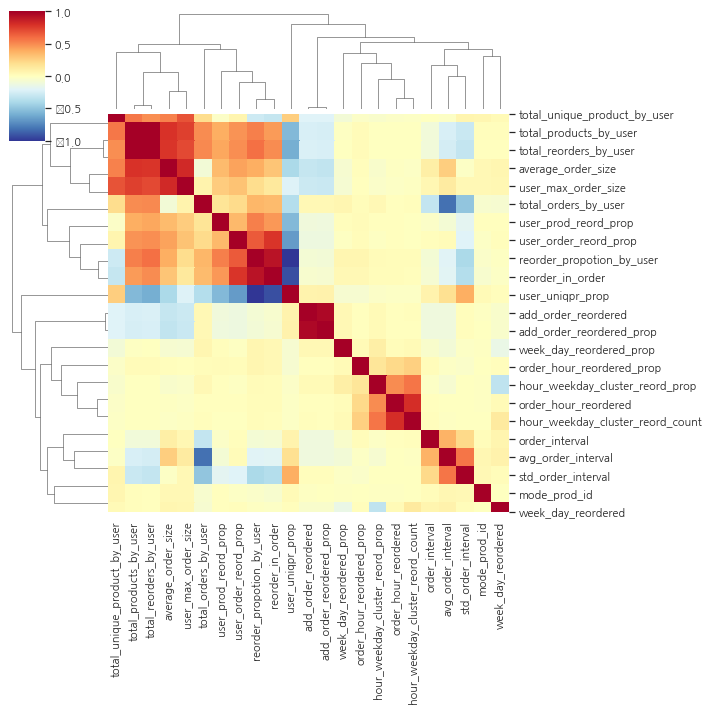

In [128]:
sns.clustermap(cor_df, 
               # annot = True, # 실제 값 화면에 나타내기 
               cmap = 'RdYlBu_r', # Red, Yellow, Blue 색상으로 표시  
               vmin = -1,
               vmax = 1
              )

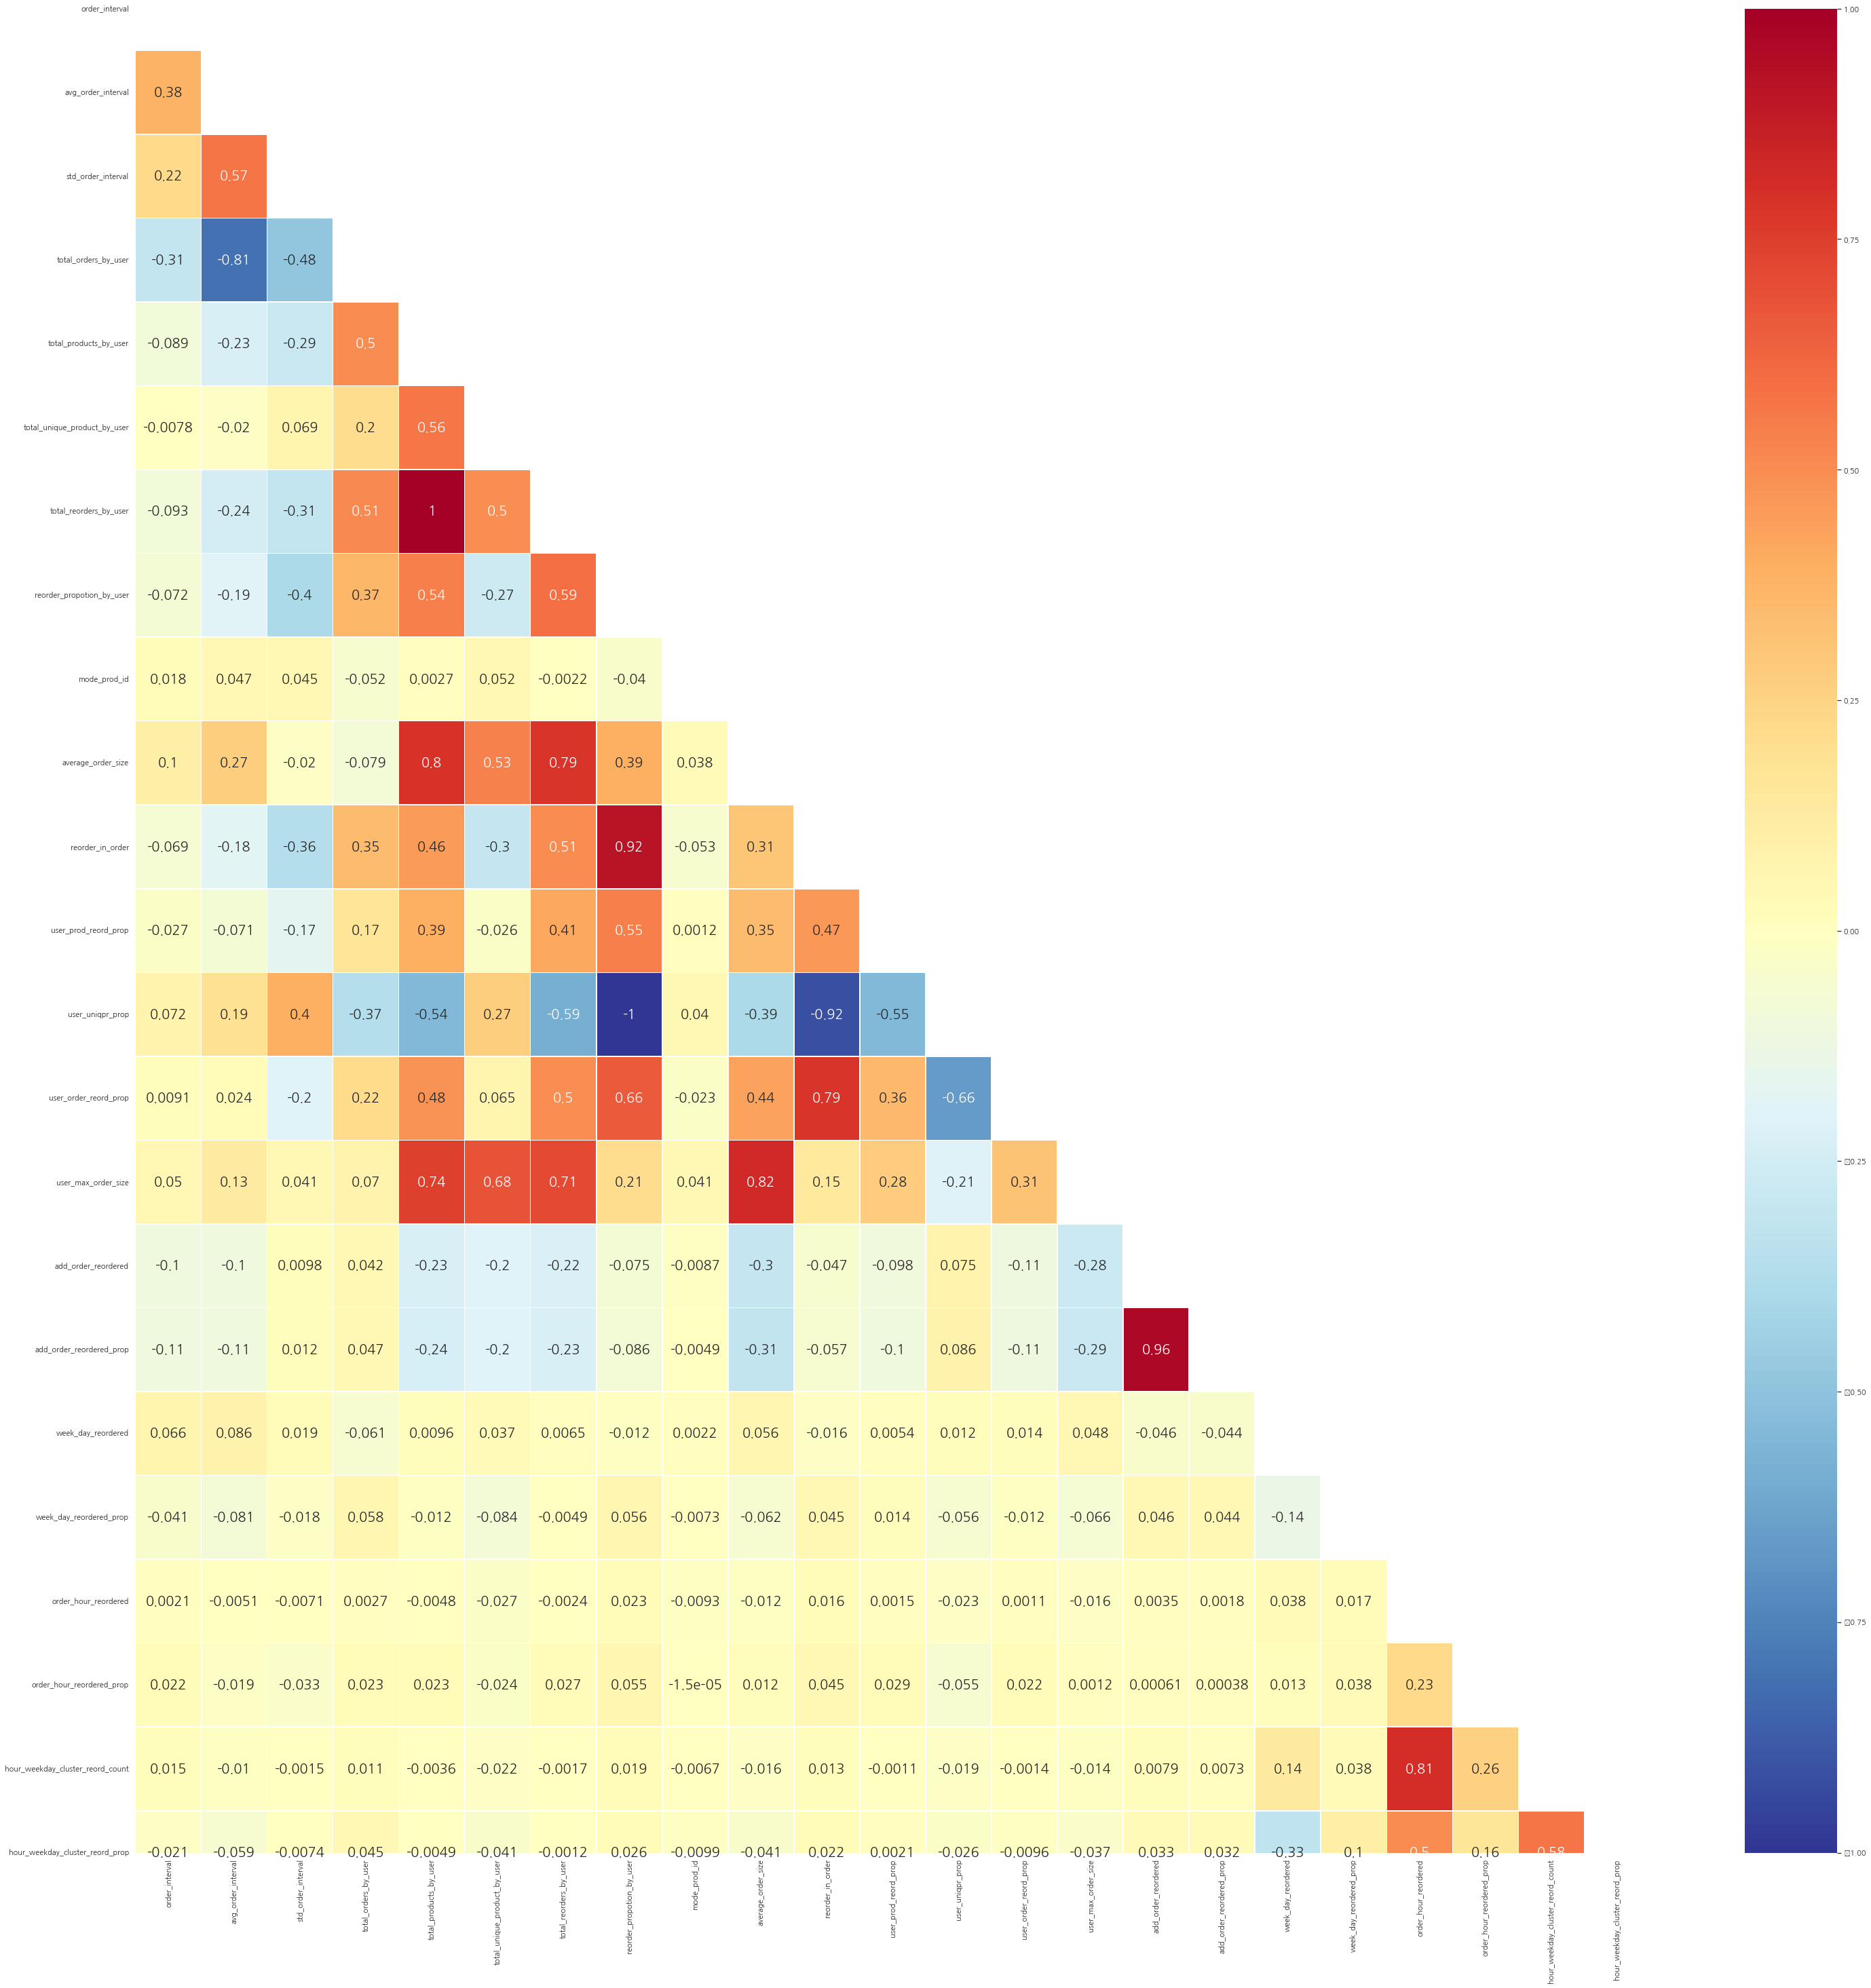

In [204]:
fig, ax = plt.subplots( figsize = (50, 50) ) 
plt.rc('font', size = 30)
plt.rc('axes', labelsize = 30)

# 삼각형 마스크  
mask = np.zeros_like(cor_df, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그린다 
sns.heatmap(cor_df,
            cmap = 'RdYlBu_r',
            annot = True, # 실제 값을 표기한다
            annot_kws = {'size':20}, # 값 size 20
            mask = mask, # 표시하지 않을 마스크 부분을 지정한다
            linewidths = 0.5, # 경계면 실선으로 구분하기 
            # cbar_kws = ['shrink', .5], # 컬러바 크기 절반으로 줄임
            vmin = -1, vmax = 1 # 컬러바범위 -1 ~ 1
)
# plt.show()

In [205]:
# x_train[['total_reorders_by_user', 'total_products_by_user', 'user_uniqpr', 'total_unique_product_by_user']]

## 변수 선택

##### 변수 선택결과로 KBEST 알고리즘을 통해 최종 선택함

- 선택 결과 고객이 어떤상품을 가장 많이 샀는지, 상품은 다양하게 샀는지, 최근에는 어떤 상품을 샀는지가 주요 파생변수로 확인됨

In [129]:
def memory_usage(data_frame):
    return data_frame.memory_usage(deep=True).sum()/1024**2


def reduce_memory(data_frame):
    memory_before = memory_usage(data_frame)
    print('before: {:.2f} MB'.format(memory_before))
    subtype_int = ['uint8','uint16','uint32','uint64','int8','int16','int32','int64']
    subtype_float = ['float16','float32','float64']
    for col in data_frame.columns:
        col_type = str(data_frame[col].dtypes)
        mx_col = data_frame[col].max()
        mn_col = data_frame[col].min()
        if 'int'in col_type:
            for ele in subtype_int:
                if mn_col>np.iinfo(ele).min and mx_col<np.iinfo(ele).max:
                    data_frame[col] = data_frame[col].astype(ele)
                    break
        
        elif 'float' in col_type:
            for ele in subtype_float:
                if mn_col>np.finfo(ele).min and mx_col<np.finfo(ele).max:
                    data_frame[col] = data_frame[col].astype(ele)
                    break  
        elif 'object' in col_type:
                if col=='product_id':
                    data_frame['product_id'] = pd.to_datetime(data_frame['product_id'],format='%Y-%m-%d')
                else:
                    numbr_of_unique = len(df[col].unique())
                    numbr_total = len(df[col])
                    if numbr_of_unique/numbr_total<0.5:
                        
                        df[col] = df[col].astype('category')
    memory_after = memory_usage(data_frame)
    print('after:{:.2f} MB'.format(memory_after))
    print('Decreased by: {:.2f} % '.format(100*(memory_before-memory_after)/memory_before))



In [130]:
ohe_x_train['order_interval'] = ohe_x_train['order_interval'].astype('float32')
ohe_x_valid['order_interval'] = ohe_x_valid['order_interval'].astype('float32')

In [131]:
reduce_memory(ohe_x_train)

before: 539.34 MB
after:385.07 MB
Decreased by: 28.60 % 


In [132]:
ohe_x_train.memory_usage(deep=True).sum()/1024**2

385.07364654541016

In [133]:
reduce_memory(ohe_x_valid)

before: 9.60 MB
after:6.59 MB
Decreased by: 31.31 % 


In [134]:
ohe_x_valid.memory_usage(deep=True).sum()/1024**2

6.591789245605469

In [135]:
ohe_x_train['order_interval'] = ohe_x_train['order_interval'].fillna(0)

In [136]:
for i in range(round(len(ohe_x_train.columns)/10)):
    globals()['ohe_x_train'+str(i)] = ohe_x_train.iloc[:]

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# f_select = SelectKBest(chi2, k = 20)
# f_select.fit(ohe_x_train2, y_train)
# f_scores = pd.DataFrame()

f_select = SelectKBest(chi2, k = 50)
f_select.fit(ohe_x_train, y_train)
chi2_scores = pd.DataFrame()

chi2_scores['mutual_info_classif'] = f_select.scores_
chi2_scores['p'] = f_select.pvalues_
chi2_scores['support'] = f_select.get_support()
chi2_scores['attribute'] = ohe_x_train2.columns
chi2_select = chi2_scores[chi2_scores['support'] == True]

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# f_select = SelectKBest(chi2, k = 20)
# f_select.fit(ohe_x_train2, y_train)
# f_scores = pd.DataFrame()

f_select = SelectKBest(f_classif, k = 50)
f_select.fit(ohe_x_train, y_train)
f_classif_scores = pd.DataFrame()

f_classif_scores['mutual_info_classif'] = f_select.scores_
f_classif_scores['p'] = f_select.pvalues_
f_classif_scores['support'] = f_select.get_support()
f_classif_scores['attribute'] = ohe_x_train2.columns
f_classif_select = f_classif_scores[f_classif_scores['support'] == True]

In [139]:
good_feats = chi2_select.merge(f_classif_select, on = ['attribute'], how='inner')['attribute']

In [151]:
good_feats

0             total_products_by_user
1       total_unique_product_by_user
2                       mode_prod_id
4                user_max_order_size
5                add_order_reordered
6                        add_order_1
7            category_class_prod_1_8
8           category_class_prod_1_17
9           category_class_prod_1_18
10          category_class_prod_1_23
11          category_class_prod_1_27
12          category_class_prod_1_30
13           category_class_prod_2_4
14           category_class_prod_2_8
15          category_class_prod_2_17
16          category_class_prod_2_18
17          category_class_prod_2_23
18          category_class_prod_2_27
19          category_class_prod_2_30
20           category_class_prod_3_3
21           category_class_prod_3_4
22           category_class_prod_3_8
23          category_class_prod_3_17
24          category_class_prod_3_18
25          category_class_prod_3_23
26          category_class_prod_3_27
27          category_class_prod_3_30
2

In [150]:
good_feats.drop([3], inplace=True)

In [259]:
good_feats.drop([41,42,43], inplace=True)

In [260]:
good_feats.to_pickle('data/good_feats.pkl')

In [153]:
# chi2_select / f_classif 간 공통적으로 선택하지 않은 부분 확인
chi2_select.merge(f_classif_select, on = ['attribute'], how='inner')
check_feature_uncommon = chi2_select.merge(f_classif_select, on = ['attribute'], how='outer', indicator='flag')
check_feature_uncommon.loc[check_feature_uncommon['flag'] == 'left_only', : ]
check_feature_uncommon.loc[check_feature_uncommon['flag'] == 'right_only', : ]

mutual_info_classif_x  p_x support_x                 attribute  \
50                    NaN  NaN       NaN  add_order_reordered_prop   
51                    NaN  NaN       NaN            is_reordered_0   
52                    NaN  NaN       NaN            is_reordered_1   
53                    NaN  NaN       NaN   category_class_prod_1_9   
54                    NaN  NaN       NaN   category_class_prod_2_9   
55                    NaN  NaN       NaN   category_class_prod_3_9   

    mutual_info_classif_y  p_y support_y        flag  
50             676.357989  0.0      True  right_only  
51             346.137244  0.0      True  right_only  
52             346.137244  0.0      True  right_only  
53             393.763839  0.0      True  right_only  
54             426.967165  0.0      True  right_only  
55             407.770044  0.0      True  right_only

In [266]:
def hyper_parameter_tuning( model, name, x_train = ohe_x_train[good_feats], x_valid = ohe_x_valid[good_feats], y_train = y_train, y_valid = y_valid):
    

    
    # 최적 하이퍼파라미터를 사용한 모델 지정
    best_model = model.best_estimator_
    
    
    # 모델 저장
    joblib.dump(best_model,'data/{0}.pkl'.format(name))
    
    # 모델 Y값 예측
    y_train_pred =  best_model.predict(x_train)
    y_valid_pred =  best_model.predict(x_valid)

    # 정확도 예측
    acc_score_train = (y_train == y_train_pred).mean()
    acc_score_vaild = (y_valid == y_valid_pred).mean()
    
    # F1 스코어 산출, 대회규정에 맞게 고객별 구매결과에 대한 F1 SCORE산출 후 전체고객 평균으로 계산 MACRO 옵션
    F1_score_train = f1_score(y_train, y_train_pred, average='macro') 
    F1_score_vaild = f1_score(y_valid, y_valid_pred, average='macro') 
    
    #랜덤 서치 결과, 하이퍼파라미터별 평가
    hyper_params_cv = pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score').T 
    hyper_params_cv.iloc[:,:5]
    print('RandomsearchCV Result :', hyper_params_cv)
    
    # ACCURACY, F1 결과출력
    print('Train accuracy score : ', round(acc_score_train,3) , ' Train F1 score : ', round(F1_score_train,3) )
    print('Validation accuracy score : ', round(acc_score_vaild,3) , ' Validation F1 score : ', round(F1_score_vaild,3) )
    







### xgboost

- 20만개 train_current 데이터로 모델로 생성

Extreme Gradient Boosting의 약자로 Gradient Boost 알고리즘을 병렬학습이 지원되도록 구현한 모델

Boosting 앙상블 모델로 순차적으로 모델을 학습시켜서 오답에 대해 집중하여 후순위 모델을 학습

높은 성능을 나타내며 여러 파라미터를 조절해가면서 최적의 Model을 만들 수 있다.


In [38]:
from xgboost import XGBClassifier

In [60]:
model = XGBClassifier(objective='multi:softprob', eval_metric='logloss')

params = {

    'max_depth' : [3,10,15], 
    'n_estimators' : [30,50,80],
    'learning_rate' : [0.1,0.2],
    'gamma' : [0.0, 0.1, 0.4],
    'colsample_bytree': [0.7,1]
}


randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=3, n_iter=40)

randomf1.fit(ohe_x_valid[good_feats], y_valid)

hyper_parameter_tuning(name='XGBClassifier', model = randomf1)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_depth=10, n_estimators=80;, score=0.060 total time= 2.0min
[CV 2/3] END colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_depth=10, n_estimators=80;, score=0.057 total time= 1.9min
[CV 3/3] END colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_depth=10, n_estimators=80;, score=0.056 total time= 2.3min
[CV 1/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=15, n_estimators=80;, score=0.054 total time= 3.0min
[CV 2/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=15, n_estimators=80;, score=0.051 total time= 2.8min
[CV 3/3] END colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=15, n_estimators=80;, score=0.051 total time= 3.1min
[CV 1/3] END colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.062 total time=  24.8s
[CV 2/3] END colsample_bytree=1, gamma=0.4, learning_rate

In [63]:
# 랜덤CV 결과 바탕으로 지속적으로 허이퍼파리미터 튜닝
pd.DataFrame(randomf1.cv_results_).sort_values(by='rank_test_score').T.iloc[:,:20]

16  \
mean_fit_time                                                     71.6479   
std_fit_time                                                      2.28737   
mean_score_time                                                  0.234554   
std_score_time                                                  0.0188643   
param_n_estimators                                                     80   
param_max_depth                                                         3   
param_learning_rate                                                   0.2   
param_gamma                                                           0.1   
param_colsample_bytree                                                0.7   
params                  {'n_estimators': 80, 'max_depth': 3, 'learning...   
split0_test_score                                               0.0662747   
split1_test_score                                               0.0613411   
split2_test_score                                               0.0632769   
mean_test_score                                                 0.0636309   
std_test_score                                                 0.00202965   
rank_test_score                                                         1   

                                                                       29  \
mean_fit_time                                                      88.234   
std_fit_time                                                      6.54259   
mean_score_time                                                  0.263452   
std_score_time                                                  0.0466418   
param_n_estimators                                                     80   
param_max_depth                                                         3   
param_learning_rate                                                   0.2   
param_gamma                                                             0   
param_colsample_bytree                                                  1   
params                  {'n_estimators': 80, 'max_depth': 3, 'learning...   
split0_test_score                                               0.0675706   
split1_test_score                                               0.0598379   
split2_test_score                                               0.0595307   
mean_test_score                                                 0.0623131   
std_test_score                                                 0.00371977   
rank_test_score                                                         2   

                                                                       13  \
mean_fit_time                                                     45.4824   
std_fit_time                                                      1.05968   
mean_score_time                                                  0.181012   
std_score_time                                                  0.0293288   
param_n_estimators                                                     50   
param_max_depth                                                         3   
param_learning_rate                                                   0.2   
param_gamma                                                           0.4   
param_colsample_bytree                                                0.7   
params                  {'n_estimators': 50, 'max_depth': 3, 'learning...   
split0_test_score                                                0.066438   
split1_test_score                                               0.0589536   
split2_test_score                                               0.0614809   
mean_test_score                                                 0.0622908   
std_test_score                                                 0.00310869   
rank_test_score                                                         3   

                                                                       33  \
mean_fit_time                                                   

### RandomForest

- 20만개 train_current 데이터로 모델로 생성

Decision Tree의 특정 데이터에만 잘 작동할 가능성이 크다는 단점을 극복하기 위해 만들어진 알고리즘으로, 같은 데이터에 대하여 Decision Tree를 여러 개 만들어, 그 결과를 종합해 내는 방식이다. 이와 같은 기법을 앙상블 이라고 하는데, 이를 통해 정확도와 안정성을 높일 수 있다. 
이 때, 많은 decision tree를 생성해내기 위해서 bootstraping을 하는데 이 때 bagging을 통해 random하게 샘플을 뽑고 boosting을 통해 여러개의 모델에 fitting 시킨다. 이 때, 랜덤포레스트는 tree를 더 많이 fitting 시킨다고 더 많이 fitting되지 않는다.


In [58]:

from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier()


model = RandomForestClassifier( class_weight = 'balanced')

params = {
 
    'max_depth' : [10,15,20],
    'max_features' : [5,10,12],
    'n_estimators' : [80,100,150,200],    
     'min_samples_split' : [5,10,20]
}


randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=3, n_iter=40)

randomf1.fit(ohe_x_valid[good_feats], y_valid)

hyper_parameter_tuning(name='RandomForestClassifier', model = randomf1)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END max_depth=15, max_features=10, min_samples_split=20, n_estimators=150;, score=0.045 total time=   3.5s
[CV 2/3] END max_depth=15, max_features=10, min_samples_split=20, n_estimators=150;, score=0.048 total time=   3.3s
[CV 3/3] END max_depth=15, max_features=10, min_samples_split=20, n_estimators=150;, score=0.046 total time=   3.3s
[CV 1/3] END max_depth=15, max_features=5, min_samples_split=10, n_estimators=80;, score=0.044 total time=   1.4s
[CV 2/3] END max_depth=15, max_features=5, min_samples_split=10, n_estimators=80;, score=0.046 total time=   1.4s
[CV 3/3] END max_depth=15, max_features=5, min_samples_split=10, n_estimators=80;, score=0.041 total time=   1.4s
[CV 1/3] END max_depth=15, max_features=3, min_samples_split=10, n_estimators=100;, score=0.043 total time=   1.5s
[CV 2/3] END max_depth=15, max_features=3, min_samples_split=10, n_estimators=100;, score=0.045 total time=   1.5s
[CV 3/3] END max_d

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()

params = {
        'objective' : 'multiclass', 
    'boosting_type' : 'gbdt' , 
    'n_estimators': [200, 500, 1000, 2000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0], 
    'subsample': [0.8, 0.9, 1.0],



}


# randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=5, n_iter=50)
randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=1, n_iter=1 )

randomf1.fit(ohe_x_valid[good_feats], y_valid)

hyper_parameter_tuning(name='LGBMRegressor', model = randomf1)

TypeError: __init__() got an unexpected keyword argument 'n_folds'

### XGBOOST 기존

- 120만개 train_past 데이터로 모델로 생성

In [ ]:
model = XGBClassifier(objective='multi:softprob', eval_metric='logloss')

# params = {

#     'max_depth' : [3,4,5,6,7,8,10,12,15], 
#     'n_estimators' : [10,50,100],
#     'learning_rate' : [0.05,0.1,0.15,0.2,0.25,0.3],
#     'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4],
#     'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
# }


params = {

    'max_depth' : [3,10,15], 
    'n_estimators' : [30,50,80],
    'learning_rate' : [0.05,0.1,0.2,0.3],
    'gamma' : [0.0, 0.1, 0.4],
    'colsample_bytree': [0.3, 0.7,1]
}


randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=5, n_iter=70)

randomf1.fit(ohe_x_train[good_feats], y_train)

hyper_parameter_tuning(name='XGBClassifier_OG', model = randomf1)

### RandomForest 기존

- 120만개 train_past 데이터로 모델로 생성

In [262]:
ohe_x_train[good_feats]

total_products_by_user  total_unique_product_by_user  mode_prod_id  \
0                           266                            42         35221   
1                           266                            42         35221   
2                           266                            42         35221   
3                           172                            15         35951   
4                           172                            15         35951   
...                         ...                           ...           ...   
1278391                     523                            37         24184   
1278392                     523                            37         24184   
1278393                     523                            37         24184   
1278394                     523                            37         24184   
1278395                     523                            37         24184   

         user_max_order_size  add_order_reordered  add_order_1  \
0                         10               119334            1   
1                         10               108435            0   
2                         10                58936            0   
3                          7                50634            0   
4                          7               119334            1   
...                      ...                  ...          ...   
1278391                   19                 2441            0   
1278392                   19                97480            0   
1278393                   19                58936            0   
1278394                   19                67401            0   
1278395                   19                17569            0   

         category_class_prod_1_8  category_class_prod_1_17  \
0                              0                         0   
1                              0                         0   
2                              0                         0   
3                              0                         0   
4                              0                         0   
...                          ...                       ...   
1278391                        1                         0   
1278392                        1                         0   
1278393                        1                         0   
1278394                        1                         0   
1278395                        1                         0   

         category_class_prod_1_18  category_class_prod_1_23  ...  \
0                               0                         0  ...   
1                               0                         0  ...   
2                               0                         0  ...   
3                               0                         0  ...   
4                               0                         0  ...   
...                           ...                       ...  ...   
1278391                         0                         0  ...   
1278392                         0                         0  ...   
1278393                         0                         0  ...   
1278394                         0                         0  ...   
1278395                         0                         0  ...   

         category_class_mode_prod_id_5  category_class_mode_prod_id_8  \
0                                    0                              0   
1                                    0                              0   
2                                    0                              0   
3                                    0                              0   
4                                    0                              0   
...                                ...                            ...   
1278391                              0                              0   
1278392                              0                              0   
1278393                              0          

In [264]:

from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier()


model = RandomForestClassifier( class_weight = 'balanced')

params = {
 
 
    'max_depth' : [30],
    'max_features' : [30],
    'n_estimators' : [40],    
     'min_samples_split' : [10]
}


randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=2, n_iter=1)

randomf1.fit(ohe_x_train[good_feats], y_train)

hyper_parameter_tuning(name='RandomForestClassifier_OG', model = randomf1)




Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END max_depth=30, max_features=30, min_samples_split=10, n_estimators=40;, score=0.136 total time= 2.7min
[CV 2/2] END max_depth=30, max_features=30, min_samples_split=10, n_estimators=40;, score=0.136 total time= 2.8min


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=1,
                   param_distributions={'max_depth': [30], 'max_features': [30],
                                        'min_samples_split': [10],
                                        'n_estimators': [40]},
                   scoring='f1_macro', verbose=3)

In [267]:
hyper_parameter_tuning(name='RandomForestClassifier_OG_2', model = randomf1)

RandomsearchCV Result :                                                                          0
mean_fit_time                                                        128.1
std_fit_time                                                       2.18245
mean_score_time                                                     38.013
std_score_time                                                    0.256082
param_n_estimators                                                      40
param_min_samples_split                                                 10
param_max_features                                                      30
param_max_depth                                                         30
params                   {'n_estimators': 40, 'min_samples_split': 10, ...
split0_test_score                                                  0.13567
split1_test_score                                                 0.135679
mean_test_score                                                   0.135674
s

In [78]:
# estimator 80
# max_depth = 3
# learning rate = 0.2
# param_gamma = 0.1	
# param_colsample_bytree = 0.7
pd.DataFrame(randomf1.cv_results_).sort_values(by='rank_test_score').T.iloc[:,:20]

13  \
mean_fit_time                                                      119.387   
std_fit_time                                                       3.38606   
mean_score_time                                                     34.767   
std_score_time                                                    0.124975   
param_n_estimators                                                      40   
param_min_samples_split                                                 10   
param_max_features                                                      30   
param_max_depth                                                         30   
params                   {'n_estimators': 40, 'min_samples_split': 10, ...   
split0_test_score                                                 0.135971   
split1_test_score                                                 0.135872   
mean_test_score                                                   0.135922   
std_test_score                                                  4.9699e-05   
rank_test_score                                                          1   

                                                                        12  \
mean_fit_time                                                      89.4063   
std_fit_time                                                       2.50787   
mean_score_time                                                    34.7833   
std_score_time                                                    0.546053   
param_n_estimators                                                      40   
param_min_samples_split                                                 10   
param_max_features                                                      20   
param_max_depth                                                         30   
params                   {'n_estimators': 40, 'min_samples_split': 10, ...   
split0_test_score                                                 0.135723   
split1_test_score                                                 0.134741   
mean_test_score                                                   0.135232   
std_test_score                                                  0.00049089   
rank_test_score                                                          2   

                                                                        8   \
mean_fit_time                                                      82.0739   
std_fit_time                                                       1.94518   
mean_score_time                                                     31.855   
std_score_time                                                    0.629374   
param_n_estimators                                                      40   
param_min_samples_split                                                 10   
param_max_features                                                      20   
param_max_depth                                                         25   
params                   {'n_estimators': 40, 'min_samples_split': 10, ...   
split0_test_score                                                 0.133853   
split1_test_score                                                 0.134732   
mean_test_score                                                   0.134292   
std_test_score                                                 0.000439339   
rank_test_score                                                          3   

                                                                        7   \
mean_fit_time                                                      70.1166   
std_fit_time                                                      0.147526   
mean_score_time                                                      33.25   
std_score_time                                                   0.0561866   
param_n_estimators                                                      40   
param_min_samples_split                                                 10   
param_max_fea

# testset으로 y_test 생성
* test_x_past의 order interval 결측치 0으로 대치

In [4]:
### pickle 데이터 로딩 
root = 'data/'  
with open(root + 'test_x_past.pkl', 'rb') as f : 
    test_x_past = pickle.load(f)
with open(root + 'test_x_current.pkl', 'rb') as f : 
    test_x_current = pickle.load(f)    
with open(root + 'df_products_info.pkl', 'rb') as f : 
    df_products_info = pickle.load(f)

In [5]:
test_x_past.loc[test_x_past['order_interval']=='','order_interval'] = 0

In [6]:
test_x_past = test_x_past.astype({
        'order_id' : 'object',  
        'cstno' : 'object',  
        'order_number' : 'int',  
        'week_day' : 'int',  
        'order_hour' : 'int',  
        'order_interval' : 'float64' , 
        'add_order' : 'int',  
        'is_reordered' : 'int', 
        'product_id' : 'object'
})

In [7]:
test_x_current

order_id   cstno order_number week_day order_hour order_interval  \
0      3384204   37987           38        5         16           13.0   
1      2578612  169022           38        6         10            7.0   
2       188887  200090           45        5         16           30.0   
3       646772  149416           39        1         13           13.0   
4       300214  113836           42        3         10           17.0   
...        ...     ...          ...      ...        ...            ...   
16121  2047884   57077           46        5         15            8.0   
16122   567625   83592           43        4         12            0.0   
16123   596442  157740           49        6         10            3.0   
16124   671102   92043           43        4         10           10.0   
16125   529654   62871           58        4          8            8.0   

      add_order is_reordered  
0             9            1  
1             4            1  
2             5            1  
3            15            1  
4             1            1  
...         ...          ...  
16121         2            1  
16122         1            1  
16123         2            1  
16124         1            1  
16125        22            1  

[16126 rows x 8 columns]

In [8]:
test_x_past.loc[test_x_past['order_number'] == '1', 'is_first_order'] = 1 
test_x_past.loc[test_x_past['is_first_order'].isnull(), 'is_first_order'] = 0
test_x_current.loc[test_x_current['order_number'] == '1', 'is_first_order'] = 1 
test_x_current.loc[test_x_current['is_first_order'].isnull(), 'is_first_order'] = 0
#test_current = pd.concat([test_x_current, test_y], axis=1).sort_values(by=['order_id'], ascending=False).reset_index(drop=True) 
test_x_current['is_past_current'] = 'current' 
test_x_current = test_x_current.reset_index(drop=True) 
test_x_past['is_past_current'] = 'past'
test_x_past = test_x_past.reset_index(drop=True) 
test_x_past

order_id   cstno  order_number  week_day  order_hour  order_interval  \
0        117004  186630            37         4          11             3.0   
1        128658  186630            20         2          10             6.0   
2        165882  186630            56         3          15             5.0   
3        180165  186630            17         1          16             4.0   
4        394948  186630            46         5          11             7.0   
...         ...     ...           ...       ...         ...             ...   
541917  2672845  119134            39         1          14            17.0   
541918  2731678  119134            38         5          14             3.0   
541919  2860406  119134             9         5           9             8.0   
541920  3252013  119134             4         5          10             7.0   
541921  3275894  119134            16         4          10             3.0   

        add_order  is_reordered product_id  is_first_order is_past_current  
0              12             1      21709             0.0            past  
1               4             1      21709             0.0            past  
2              10             1      21709             0.0            past  
3               4             1      21709             0.0            past  
4               7             1      21709             0.0            past  
...           ...           ...        ...             ...             ...  
541917          4             1      24852             0.0            past  
541918          4             1      24852             0.0            past  
541919          1             1      24852             0.0            past  
541920          2             1      24852             0.0            past  
541921         10             1      24852             0.0            past  

[541922 rows x 11 columns]

In [9]:
df_products_info = df_products_info.astype({'product_id': 'int'})
test_x_past = test_x_past.astype({'product_id': 'int'})

In [10]:
test_x_past = pd.merge(left = test_x_past, right = df_products_info, left_on = 'product_id', right_on = 'product_id').sort_values(by=['order_id'], ascending=False).reset_index(drop=True) 
test_x_past

order_id   cstno  order_number  week_day  order_hour  order_interval  \
0        999965   82895            61         4          12             0.0   
1        999965   82895            61         4          12             0.0   
2        999965   82895            61         4          12             0.0   
3        999963   63992            34         2          15            10.0   
4        999963   63992            34         2          15            10.0   
...         ...     ...           ...       ...         ...             ...   
541917  1000073   47257             5         4          10             0.0   
541918  1000033  203670            16         4          13             4.0   
541919  1000033  203670            16         4          13             4.0   
541920  1000033  203670            16         4          13             4.0   
541921     1000   49841             7         1          17             5.0   

        add_order  is_reordered  product_id  is_first_order is_past_current  \
0               2             1       27966             0.0            past   
1               4             1       26604             0.0            past   
2               5             1       13176             0.0            past   
3               4             1       24852             0.0            past   
4               5             1       25890             0.0            past   
...           ...           ...         ...             ...             ...   
541917         15             1        9387             0.0            past   
541918          1             1       27845             0.0            past   
541919          7             1       22935             0.0            past   
541920         11             0       19057             0.0            past   
541921          3             0       35951             0.0            past   

                                        name category_id division_id  \
0                        Organic Raspberries         123           4   
1                       Organic Blackberries          24           4   
2                     Bag of Organic Bananas          24           4   
3                                     Banana          24           4   
4          Boneless Skinless Chicken Breasts          49          12   
...                                      ...         ...         ...   
541917                   Granny Smith Apples          24           4   
541918                    Organic Whole Milk          84          16   
541919                  Organic Yellow Onion          83           4   
541920  Organic Large Extra Fancy Fuji Apple          24           4   
541921       Organic Unsweetened Almond Milk          91          16   

                     category_name division_name  
0       packaged vegetables fruits       produce  
1                     fresh fruits       produce  
2                     fresh fruits       produce  
3                     fresh fruits       produce  
4                 packaged poultry  meat seafood  
...                            ...           ...  
541917                fresh fruits       produce  
541918                        milk    dairy eggs  
541919            fresh vegetables       produce  
541920                fresh fruits       produce  
541921             soy lactosefree    dairy eggs  

[541922 rows x 16 columns]

In [11]:
df_products_info = df_products_info.astype({'product_id': 'object'})
test_x_past = test_x_past.astype({'product_id': 'object'})

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


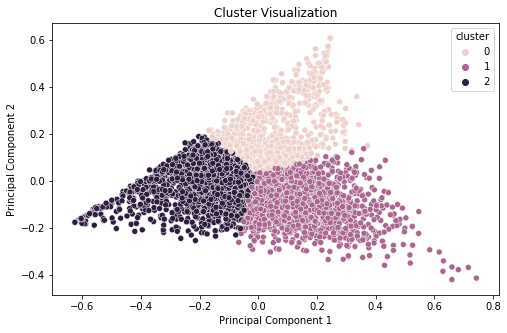

In [25]:
test_x_past = make_hour_weekday_cluster(test_x_past)
test_user_feats = make_user_feats(df = test_x_past)
test_atc_features = make_add_order_feats(df = test_x_past)
test_week_day_features = make_weekday_feats(test_x_past)
test_order_hour_features = make_order_hours_feats(test_x_past)
test_hour_weekday_cluster_features = make_hour_weekday_cluster_feats(test_x_past)
test_category_class_features = category_class(test_x_past)
test_pca_df, test_cross_df = run_pca(test_x_past)
test_Kluster_Info = run_kmeans(test_pca_df, test_cross_df)

In [26]:
test_x_current = test_x_current.astype({'add_order' : 'int', 'week_day' : 'int', 'order_hour': 'int'})

In [27]:
test_week_day_features = test_week_day_features.astype({'week_day':'int'})

In [36]:
test_x_current_v2 = make_hour_weekday_cluster(test_x_current)
test_x_current_v2 = test_x_current_v2.merge(test_user_feats, on = 'cstno', how = 'left')
test_x_current_v2 = test_x_current_v2.merge(test_atc_features, on = 'add_order', how = 'left')
test_x_current_v2 = test_x_current_v2.merge(test_week_day_features, on = 'week_day', how = 'left')
test_x_current_v2 = test_x_current_v2.merge(test_order_hour_features, on = 'order_hour', how = 'left')
test_x_current_v2 = test_x_current_v2.merge(test_category_class_features, left_on = 'prod_1', right_on = 'product_id', how = 'left', suffixes=['','_prod_1'])
test_x_current_v2 = test_x_current_v2.merge(test_category_class_features, left_on = 'prod_2', right_on = 'product_id', how = 'left', suffixes=['','_prod_2']) 
test_x_current_v2 = test_x_current_v2.merge(test_category_class_features, left_on = 'prod_3', right_on = 'product_id', how = 'left', suffixes=['','_prod_3']) 
test_x_current_v2 = test_x_current_v2.merge(test_category_class_features, left_on = 'mode_prod_id', right_on = 'product_id', how = 'left', suffixes=['','_mode_prod_id']) 
test_x_current_v2 = test_x_current_v2.merge(test_hour_weekday_cluster_features, on = 'hour_weekday_cluster', how = 'left')
test_x_current_v2.rename(columns = {'product_id' : 'product_id_prod_1', 'category_class' : 'category_class_prod_1'}, inplace = True)
test_x_current_v2= test_x_current_v2.drop(['product_id_prod_1','product_id_prod_2','product_id_prod_3','product_id_mode_prod_id'], axis=1)
test_x_current_v2 = pd.merge(test_x_current_v2, test_Kluster_Info, on=['cstno'], how='left')

In [37]:
test_x_current = test_x_current_v2

x_test= test_x_current.drop(['order_id','cstno','order_number','week_day','order_hour',
                      'orders_3', 'orders_2', 'orders_1', 'cate_3',
                       'cate_2', 'cate_1', 'divi_3', 'divi_2', 'divi_1', 'prod_3', 'prod_2','prod_1', 'reorder_3', 'reorder_2', 
                       'reorder_1'], axis=1)

In [38]:
x_test= x_test.drop(['is_past_current'],axis=1 )

In [39]:
num_feats = ['order_interval',  
'avg_order_interval', 'std_order_interval', 'total_orders_by_user',
'total_products_by_user', 'total_unique_product_by_user',
'total_reorders_by_user', 'reorder_propotion_by_user', 'mode_prod_id',
'average_order_size', 'reorder_in_order', 'user_prod_reord_prop',
'user_uniqpr_prop', 'user_order_reord_prop',
'user_max_order_size', 'add_order_reordered',
'add_order_reordered_prop', 'week_day_reordered', 'week_day_reordered_prop',
'order_hour_reordered', 'order_hour_reordered_prop',
'hour_weekday_cluster_reord_count', 'hour_weekday_cluster_reord_prop']

cate_feats = ['add_order','is_reordered', 'is_first_order', 'hour_weekday_cluster', 
'mode_week_day', 'mode_order_hour', 'category_class_prod_1', 'category_class_prod_2',
'category_class_prod_3', 'category_class_mode_prod_id', 'cluster']

In [40]:
ohe_x_test = pd.get_dummies(x_test, columns=cate_feats)
ohe_x_test

order_interval  avg_order_interval  std_order_interval  \
0               13.0            9.070796            5.923194   
1                7.0            6.562044            2.113488   
2               30.0            7.095890            6.780619   
3               13.0            8.770186            6.588103   
4               17.0            9.489796            7.771010   
...              ...                 ...                 ...   
16121            8.0            7.636364            4.566180   
16122            0.0            7.368421            4.573337   
16123            3.0            7.607477            5.473361   
16124           10.0            8.432836            4.263416   
16125            8.0            6.671429            1.674371   

       total_orders_by_user  total_products_by_user  \
0                        35                     113   
1                        36                     274   
2                        36                      73   
3                        36                     161   
4                        36                     147   
...                     ...                     ...   
16121                    40                     121   
16122                    40                      57   
16123                    41                     107   
16124                    41                     201   
16125                    41                      70   

       total_unique_product_by_user  total_reorders_by_user  \
0                                30                      83   
1                                29                     245   
2                                 7                      66   
3                                27                     134   
4                                42                     105   
...                             ...                     ...   
16121                            21                     100   
16122                             9                      48   
16123                            20                      87   
16124                            32                     169   
16125                             8                      62   

       reorder_propotion_by_user  mode_prod_id  average_order_size  ...  \
0                       0.734513         27086            3.228571  ...   
1                       0.894161         24852            7.611111  ...   
2                       0.904110         27086            2.027778  ...   
3                       0.832298         13176            4.472222  ...   
4                       0.714286         26209            4.083333  ...   
...                          ...           ...                 ...  ...   
16121                   0.826446         24852            3.025000  ...   
16122                   0.842105         24852            1.425000  ...   
16123                   0.813084         27086            2.609756  ...   
16124                   0.840796         24852            4.902439  ...   
16125                   0.885714         13176            1.707317  ...   

       category_class_mode_prod_id_24  category_class_mode_prod_id_25  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
...                               ...                             ...   
16121                               0                               0   
16122                               0                               0   
16123                               0                               0   
16124                               0                               0   
16125                               0                               0   

       category_class_mode_prod_id_26  ca

In [41]:
with open('data/good_feats.pkl', 'rb') as f : 
    good_feats = pickle.load(f)

### 학습 모델 결과 평균적으로 성능이 가장 높은 Randomforest 알고리즘 채택 

In [42]:
# 학습모델 호출
model = joblib.load('data/RandomForestClassifier_OG_2.pkl')

In [43]:
y_test_pred =  model.predict(ohe_x_test[good_feats])
y_test_pred

array(['41787', '34358', '27086', ..., '27086', '25890', '9387'],
      dtype=object)

In [44]:
test_y = pd.DataFrame(y_test_pred, columns = ['product_id'])

In [46]:
test_y.to_csv('test_y.csv', index = False)

In [45]:
test_x_past['product_id'].value_counts()

24852    34287
13176    29086
21137    20064
21903    16974
47209    16237
         ...  
4210      2253
196       2241
21709     2186
33000     2073
34358     2040
Name: product_id, Length: 100, dtype: int64

In [244]:
test_y.value_counts()

product_id
21137         5376
13176         4620
24852         4606
27845         1104
21903          929
              ... 
28842            1
34358            1
49683            1
8174             1
10749            1
Length: 99, dtype: int64

## 초기테스트용 모델

## Logistic

- 초기 테스트용 로지스틱 모델

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
ohe_x_train['order_interval'] = ohe_x_train['order_interval'].fillna(0)

In [ ]:
mf = model.fit(ohe_x_train, y_train)

In [ ]:
prediction = model.predict(ohe_x_valid)

In [ ]:
(prediction == y_valid).mean()

In [ ]:
set(prediction)

In [ ]:
df_products_info.loc[df_products_info['product_id'] == '13176',]

In [ ]:
importance = pd.DataFrame(

    data={
        'Attribute' : ohe_x_train.columns,
        'Importance' : model.coef_[0]
    }
)

importance = importance.sort_values(by='Importance', ascending=False)


In [ ]:
plt.bar(x=importance['Attribute'], height=importance['Importance'], color='#087E8B')
plt.title('Feature importances by coefficient')
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
base_df['division_name'].nunique()

### Deep Learning (KNN) 

- 초기 테스트용 knn 모델

In [185]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()
accuracies = cross_val_score(knn, ohe_x_train[good_feats], y_train, cv=5)
knn.fit(ohe_x_train[good_feats],y_train)

#Obtain accuracy
print("Train Score:",np.mean(accuracies))
print("Test Score:",knn.score(ohe_x_valid[good_feats],y_valid_pred))

#Store results in the dictionaries
result_dict_train["KNN Train Score"] = np.mean(accuracies)

y_valid_pred = knn.predict(ohe_x_valid[good_feats])
(y_valid_pred == y_valid).mean()




Train Score: 0.13525820344393819
Test Score: 0.22355060596134949


NameError: name 'result_dict_train' is not defined

In [186]:
y_valid_pred = knn.predict(ohe_x_valid[good_feats])
(y_valid_pred == y_valid).mean()

0.1221339665902391

### SVC

In [ ]:
from sklearn.svm import SVC
model = SVC()

# Random Search (분류)
from scipy.stats import randint
params = {'kernel' : ['rbf'],
				  'C' : randint(low = 0.001,  high = 100),
                  'gamma' : randint(low = 0.001, high = 100)}  



randomf1 = RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=5, n_iter=50)

randomf1.fit(ohe_x_valid[good_feats], y_valid)

hyper_parameter_tuning(name='SVC', model = randomf1)

### MLPClassifier

In [ ]:
 from sklearn.neural_network import MLPClassifier
model=MLPClassifier()

# Random Search (분류)
from scipy.stats import randint
params ={'hidden_layer_sizes': randint(low=10, high=100), 'solver': ['sgd', 'adam'], 
             'activation': ['tanh', 'relu']}


randomf1= RandomizedSearchCV(model,param_distributions=params, verbose=3 , scoring='f1_macro', cv=3, n_iter=20)

randomf1.fit(ohe_x_valid[good_feats], y_valid)

hyper_parameter_tuning(name='MLPClassifier', model = randomf1)